# Imports and Setup

In [13]:
%matplotlib inline
# loading in the necessary libraries
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from matplotlib.patches import Circle, Rectangle, Arc
from sklearn.model_selection import RepeatedStratifiedKFold
from dython.nominal import associations
import shap
from catboost import CatBoostClassifier, Pool, cv
from catboost import CatBoostClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
import datetime as dt
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import requests
import hyperopt
'''
Stratified K-Fold comes into play for those data sets which are imbalance data
sets. This cross validation method is a slight variation in the K-Fold cross
validation, such that each fold contains approximately same percentage of
samples of each target class, or in case of prediction problems, the mean
response value is approximately equal in
all the folds.

Repeated means that K-fold is completed many different times possibly
'''

'\nStratified K-Fold comes into play for those data sets which are imbalance data\nsets. This cross validation method is a slight variation in the K-Fold cross\nvalidation, such that each fold contains approximately same percentage of\nsamples of each target class, or in case of prediction problems, the mean\nresponse value is approximately equal in\nall the folds.\n\nRepeated means that K-fold is completed many different times possibly\n'

# Activating flake8 to make sure code meets PEP8 Standards

In [2]:
%load_ext pycodestyle_magic

In [3]:
%flake8_on

In [9]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


# Guiding Question: 

## How well can I predict if Curry makes a shot based on publicly available information from NBA.com's Advanced Stats page?

In [12]:
'''
importing the data from all of Steph Curry's field goal attempts from
NBA.com's Advanced Stats

Used the nba_api library to access the data: https://github.com/swar/nba_api
Specifically using NBA.com's shot chart detail:
https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/endpoints/
shotchartdetail.md
'''

# only need to run this once
from nba_api.stats.endpoints import shotchartdetail
shotchart = shotchartdetail.ShotChartDetail(player_id='201939',
                                            team_id='1610612744',
                                            context_measure_simple='FGA')
Curry = shotchart.get_data_frames()[0]

'''
download the Curry dataframe as a csv file
'''
# Curry.to_csv(r'/Users/connorcapitolo/Desktop/NBA/Curry shots.csv')

'\ndownload the Curry dataframe as a csv file\n'

In [15]:
'''
viewing the first five rows of the dataframe
'''
Curry = pd.read_csv(
    '/Users/connorcapitolo/Desktop/NBA/Curry-Shot-Prediction/Curry shots.csv',
    index_col=0)
Curry.head()

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,Shot Chart Detail,20900015,4,201939,Stephen Curry,1610612744,Golden State Warriors,1,11,25,...,Right Side Center(RC),24+ ft.,26,99,249,1,0,20091028,GSW,HOU
1,Shot Chart Detail,20900015,17,201939,Stephen Curry,1610612744,Golden State Warriors,1,9,31,...,Left Side Center(LC),16-24 ft.,18,-122,145,1,1,20091028,GSW,HOU
2,Shot Chart Detail,20900015,53,201939,Stephen Curry,1610612744,Golden State Warriors,1,6,2,...,Center(C),8-16 ft.,14,-60,129,1,0,20091028,GSW,HOU
3,Shot Chart Detail,20900015,141,201939,Stephen Curry,1610612744,Golden State Warriors,2,9,49,...,Left Side(L),16-24 ft.,19,-172,82,1,0,20091028,GSW,HOU
4,Shot Chart Detail,20900015,249,201939,Stephen Curry,1610612744,Golden State Warriors,2,2,19,...,Left Side Center(LC),16-24 ft.,16,-68,148,1,0,20091028,GSW,HOU


In [16]:
'''
this lets me know that there isn't any missing data in the dataset
also, the two data types are integers and strings
'''
Curry.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11928 entries, 0 to 11927
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   GRID_TYPE            11928 non-null  object
 1   GAME_ID              11928 non-null  int64 
 2   GAME_EVENT_ID        11928 non-null  int64 
 3   PLAYER_ID            11928 non-null  int64 
 4   PLAYER_NAME          11928 non-null  object
 5   TEAM_ID              11928 non-null  int64 
 6   TEAM_NAME            11928 non-null  object
 7   PERIOD               11928 non-null  int64 
 8   MINUTES_REMAINING    11928 non-null  int64 
 9   SECONDS_REMAINING    11928 non-null  int64 
 10  EVENT_TYPE           11928 non-null  object
 11  ACTION_TYPE          11928 non-null  object
 12  SHOT_TYPE            11928 non-null  object
 13  SHOT_ZONE_BASIC      11928 non-null  object
 14  SHOT_ZONE_AREA       11928 non-null  object
 15  SHOT_ZONE_RANGE      11928 non-null  object
 16  SHOT

In [17]:
'''
looking specifically at shot distance and shot location, it does appears that
there are some outliers (a shot 78 feet is almost the length of a basketball
court!)
'''
Curry.describe()

,GAME_ID,GAME_EVENT_ID,PLAYER_ID,TEAM_ID,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE
count,1.192800e+04,11928.000000,11928.0,1.192800e+04,11928.000000,11928.000000,11928.000000,11928.000000,11928.000000,11928.000000,11928.0,11928.000000,1.192800e+04
mean,2.138274e+07,266.775319,201939.0,1.610613e+09,2.399061,4.754779,28.580818,17.538565,-0.111502,130.789487,1.0,0.476190,2.014508e+07
std,2.796229e+05,168.137684,0.0,0.000000e+00,1.118473,3.337098,17.574401,10.192440,124.382070,101.555442,0.0,0.499454,2.788051e+04
min,2.090002e+07,2.000000,201939.0,1.610613e+09,1.000000,0.000000,0.000000,0.000000,-250.000000,-41.000000,1.0,0.000000,2.009103e+07
25%,2.120045e+07,106.000000,201939.0,1.610613e+09,1.000000,2.000000,13.000000,9.000000,-95.000000,23.000000,1.0,0.000000,2.012123e+07
50%,2.140068e+07,272.000000,201939.0,1.610613e+09,2.000000,4.000000,29.000000,21.000000,1.000000,141.000000,1.0,0.000000,2.015013e+07
75%,2.160065e+07,392.000000,201939.0,1.610613e+09,3.000000,7.000000,44.000000,25.000000,96.000000,217.000000,1.0,1.000000,2.017012e+07
max,2.190093e+07,752.000000,201939.0,1.610613e+09,6.000000,11.000000,59.000000,78.000000,247.000000,758.000000,1.0,1.000000,2.020030e+07


## Visualizations of Steph Curry Shots

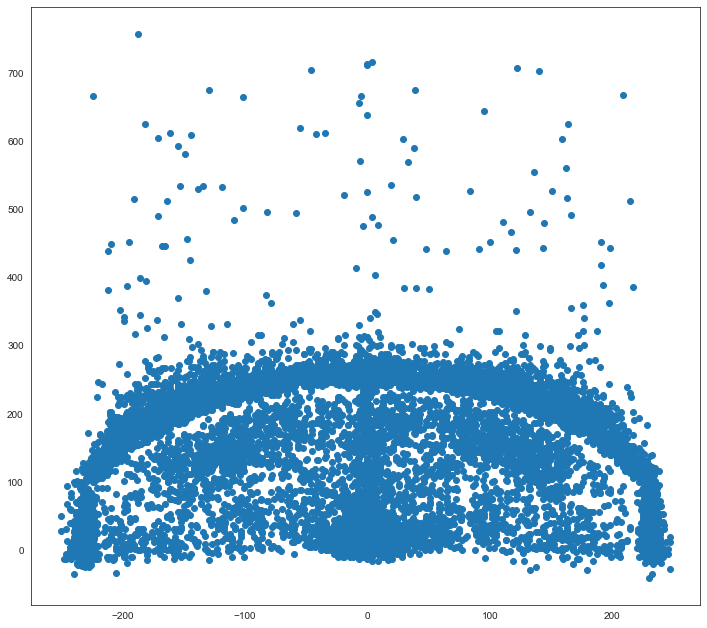

In [18]:
'''
creating a general scatter plot of all Curry's shots
'''

sns.set_style("white")
sns.set_color_codes()
plt.figure(figsize=(12, 11))
plt.scatter(Curry.LOC_X, Curry.LOC_Y)
plt.show()

These shot charts below were created courtesy of Savvas's visualizations http://savvastjortjoglou.com/nba-shot-sharts.html

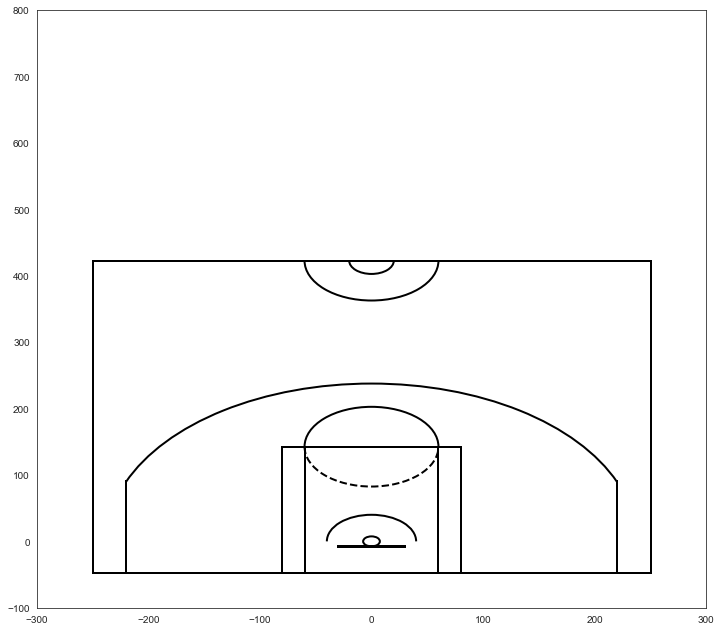

In [23]:
def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    '''Creates a basketball court through matplotlib

    Args:
        ax (axis object, optional): If an axes object isn't provided to plot
        onto, just get current one
        color (string, optional): color of the basketball court
        lw (int, optional): width of each line for the basketball court
        outer_lines (bool, optional): whether the perimeter of the court
        should be drawn
    '''
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax


plt.figure(figsize=(12, 11))
draw_court(outer_lines=True)
plt.xlim(-300, 300)
plt.ylim(-100, 800)
plt.show()

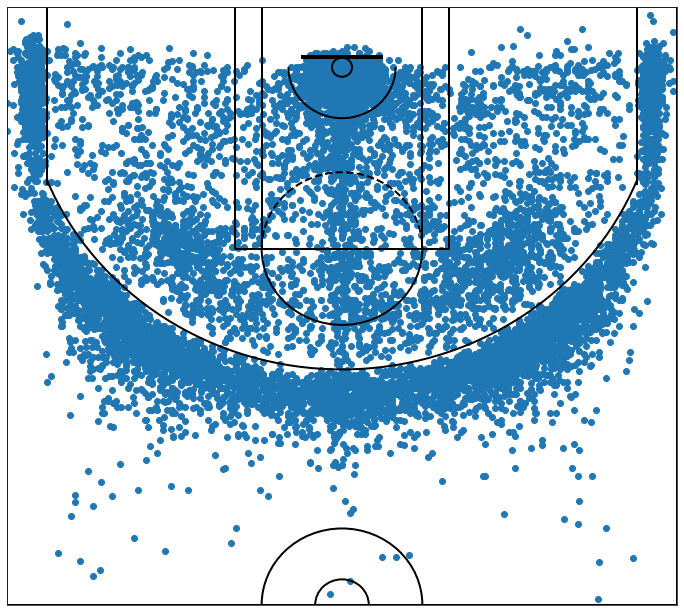

In [20]:
'''
plotting Curry's shots from inside half court
'''
plt.figure(figsize=(12, 11))
plt.scatter(Curry.LOC_X, Curry.LOC_Y)
draw_court(outer_lines=True)
# Adjust plot limits to just fit in half court
plt.xlim(-250, 250)
# Descending values along th y axis from bottom to top
# in order to place the hoop by the top of plot
plt.ylim(422.5, -47.5)
# get rid of axis tick labels
plt.tick_params(labelbottom=False, labelleft=False)
plt.show()

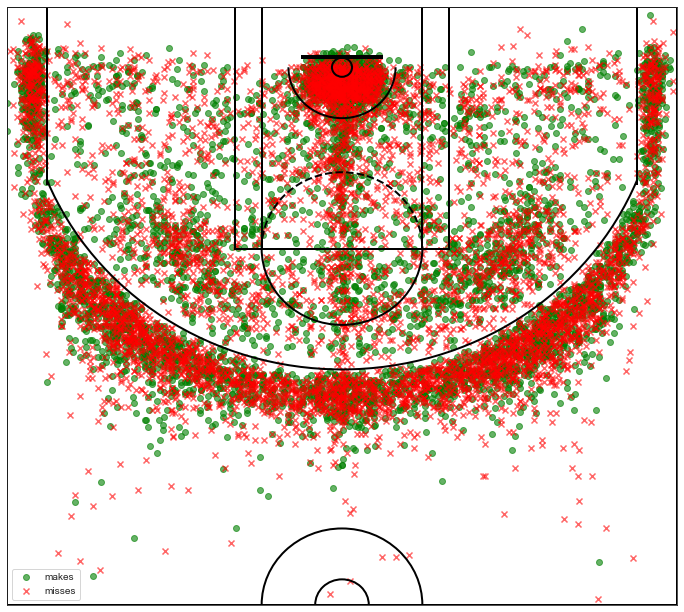

In [22]:
'''
viewing Curry's made and missed shots over the course of his career
'''
plt.figure(figsize=(12, 11))
# providing
plt.scatter(Curry.loc[Curry["SHOT_MADE_FLAG"] == 1, "LOC_X"],
            Curry.loc[Curry["SHOT_MADE_FLAG"] == 1, "LOC_Y"], c='green',
            label='makes', alpha=0.6)
plt.scatter(Curry.loc[Curry["SHOT_MADE_FLAG"] == 0, "LOC_X"],
            Curry.loc[Curry["SHOT_MADE_FLAG"] == 0, "LOC_Y"], c='red',
            marker='x', label='misses', alpha=0.6)
draw_court(outer_lines=True)
# Adjust plot limits to just fit in half court
plt.xlim(-250, 250)
# Descending values along th y axis from bottom to top
# in order to place the hoop by the top of plot
plt.ylim(422.5, -47.5)
# get rid of axis tick labels
plt.tick_params(labelbottom=False, labelleft=False)
# placing the legend in the lower left corner
plt.legend(loc='lower left')
plt.show()

In [24]:
def heatmap_Curry_shots(shot_indicator):
    '''Viewing where most of Curry's shots are made or missed

    Args:
        shot_indicator (int): a 1 if wanting to see Curry's makes, 0 if
        wanting to see Curry's misses

    Returns:
        heatmap with Curry's made or missed shots
    '''

    # n_levels sets the number of contour lines for the main kde plot
    joint_shot_chart = sns.jointplot(Curry.loc[Curry["SHOT_MADE_FLAG"] ==
                                               shot_indicator, "LOC_X"],
                                     Curry.loc[Curry["SHOT_MADE_FLAG"] ==
                                               shot_indicator, "LOC_Y"],
                                     stat_func=None,
                                     kind='kde', cmap='hsv', space=0,
                                     n_levels=50)

    joint_shot_chart.fig.set_size_inches(12, 11)

    # A joint plot has 3 Axes, the first one called ax_joint
    # is the one we want to draw our court onto and adjust some other settings
    ax = joint_shot_chart.ax_joint
    draw_court(ax)

    # Adjust the axis limits and orientation of the plot in order
    # to plot half court, with the hoop by the top of the plot
    ax.set_xlim(-250, 250)
    ax.set_ylim(422.5, -47.5)

    # Get rid of axis labels and tick marks
    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.tick_params(labelbottom='off', labelleft='off')

    # Add a title
    if shot_indicator == 1:
        plt.title('Steph Curry Made Shots (Career)')
    else:
        plt.title('Steph Curry Missed Shots (Career)')

    plt.show()

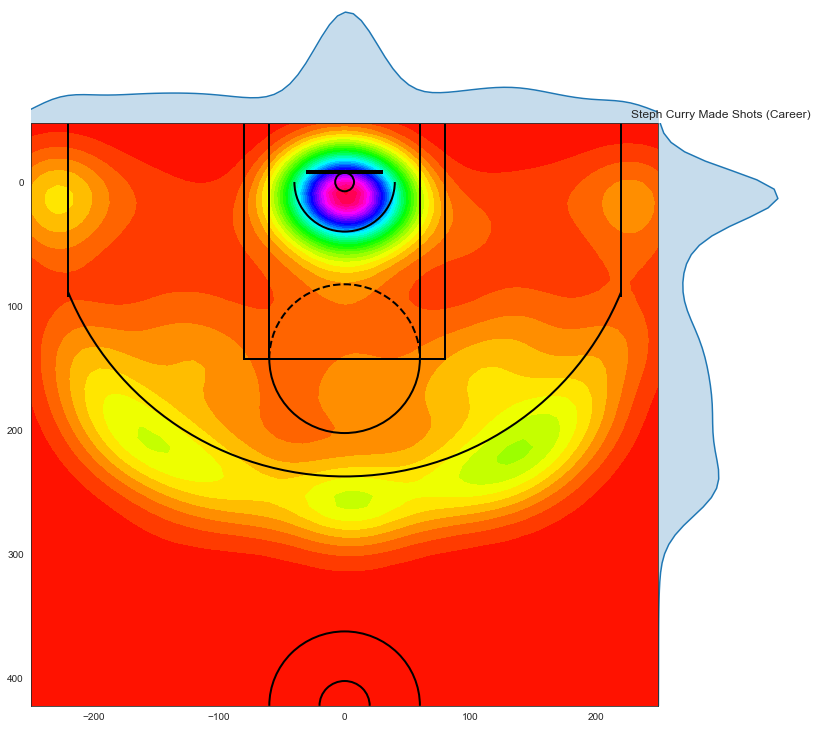

In [25]:
heatmap_Curry_shots(1)

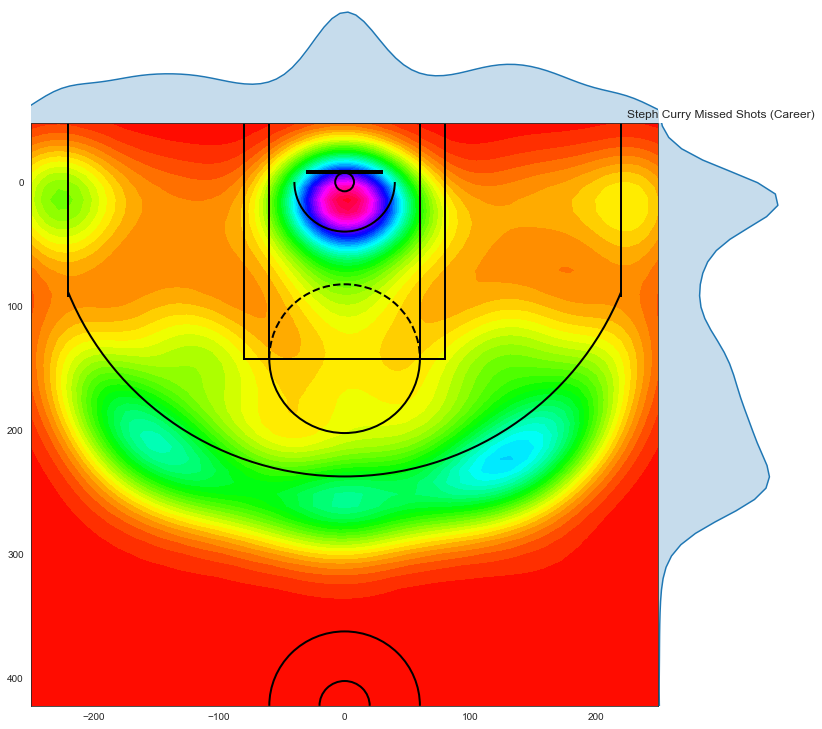

In [26]:
heatmap_Curry_shots(0)

## Dropping Unneccessary Columns (only one unique value)

In [27]:
def only_one_unique(column_list):
    '''print out the unique values in list of columns that should only have one value for Steph Curry

    Args:
        column_list(list): a list of columns to examine
    '''
    for column in column_list:
        print(Curry[column].unique())


columns = ['GRID_TYPE', 'TEAM_NAME', 'TEAM_ID', 'PLAYER_ID',
           'PLAYER_NAME', 'EVENT_TYPE', 'SHOT_ATTEMPTED_FLAG']

only_one_unique(columns)

2:80: E501 line too long (97 > 79 characters)


['Shot Chart Detail']
['Golden State Warriors']
[1610612744]
[201939]
['Stephen Curry']
['Missed Shot' 'Made Shot']
[1]


In [28]:
'''
don't need these columns b/c they are all constants throughout the dataset
'''
drop_columns_Curry = Curry.drop(
    ['GRID_TYPE', 'TEAM_NAME', 'TEAM_ID', 'PLAYER_ID', 'PLAYER_NAME', 'SHOT_ATTEMPTED_FLAG'], axis=1)
print(Curry.shape)
print(drop_columns_Curry.shape)

5:80: E501 line too long (101 > 79 characters)


(11928, 24)
(11928, 18)


In [29]:
with pd.option_context('display.max_columns', None):
    display(drop_columns_Curry.head(7))

,GAME_ID,GAME_EVENT_ID,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,20900015,4,1,11,25,Missed Shot,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,20091028,GSW,HOU
1,20900015,17,1,9,31,Made Shot,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,20091028,GSW,HOU
2,20900015,53,1,6,2,Missed Shot,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,20091028,GSW,HOU
3,20900015,141,2,9,49,Missed Shot,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,20091028,GSW,HOU
4,20900015,249,2,2,19,Missed Shot,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,20091028,GSW,HOU
5,20900015,277,2,0,34,Missed Shot,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,4,39,15,0,20091028,GSW,HOU
6,20900015,413,4,10,26,Made Shot,Pullup Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-64,149,1,20091028,GSW,HOU


In [30]:
'''
finding how many shots Curry has made and missed in his career
'''
grouped = drop_columns_Curry.groupby('EVENT_TYPE')
print(grouped['SHOT_MADE_FLAG'].size())

EVENT_TYPE
Made Shot      5680
Missed Shot    6248
Name: SHOT_MADE_FLAG, dtype: int64


In [33]:
'''
examining his percentage of makes and misses over the course of his career
'''
makes = sum(drop_columns_Curry['EVENT_TYPE'] ==
            'Made Shot') / drop_columns_Curry.shape[0]
misses = sum(drop_columns_Curry['EVENT_TYPE'] ==
             'Missed Shot') / drop_columns_Curry.shape[0]
print("Curry has made {:.3f}% and has missed {:.3f}% of his shots in his\
      career".format(
    makes, misses))

Curry has made 0.476% and has missed 0.524% of his shots in his      career


## Baseline Model must be better than 52.4%, otherwise it's better just to guess he has missed every shot in his career

# Feature Engineering

In [34]:
# checking unique values for each column
drop_columns_Curry.nunique()

GAME_ID              697
GAME_EVENT_ID        704
PERIOD                 6
MINUTES_REMAINING     12
SECONDS_REMAINING     60
EVENT_TYPE             2
ACTION_TYPE           51
SHOT_TYPE              2
SHOT_ZONE_BASIC        7
SHOT_ZONE_AREA         6
SHOT_ZONE_RANGE        5
SHOT_DISTANCE         71
LOC_X                489
LOC_Y                439
SHOT_MADE_FLAG         2
GAME_DATE            697
HTM                   32
VTM                   32
dtype: int64

In [35]:
'''
examining the columns available after dropping the known unneccesary ones
'''
print(drop_columns_Curry.columns.tolist())

['GAME_ID', 'GAME_EVENT_ID', 'PERIOD', 'MINUTES_REMAINING', 'SECONDS_REMAINING', 'EVENT_TYPE', 'ACTION_TYPE', 'SHOT_TYPE', 'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE', 'SHOT_DISTANCE', 'LOC_X', 'LOC_Y', 'SHOT_MADE_FLAG', 'GAME_DATE', 'HTM', 'VTM']


In [36]:
'''
examining the types of shots that NBA.com categorizes for Curry
'''
print(drop_columns_Curry['ACTION_TYPE'].unique())
print(len(drop_columns_Curry['ACTION_TYPE'].unique()))

['Jump Shot' 'Step Back Jump shot' 'Pullup Jump shot' 'Layup Shot'
 'Jump Bank Shot' 'Driving Layup Shot' 'Reverse Layup Shot'
 'Running Jump Shot' 'Floating Jump shot' 'Driving Finger Roll Layup Shot'
 'Running Hook Shot' 'Driving Reverse Layup Shot' 'Turnaround Jump Shot'
 'Fadeaway Jump Shot' 'Running Layup Shot' 'Running Bank shot'
 'Jump Hook Shot' 'Turnaround Bank shot' 'Driving Bank Hook Shot'
 'Running Reverse Layup Shot' 'Tip Shot' 'Fadeaway Bank shot' 'Hook Shot'
 'Pullup Bank shot' 'Finger Roll Layup Shot' 'Slam Dunk Shot'
 'Turnaround Fadeaway shot' 'Driving Dunk Shot' 'Driving Jump shot'
 'Hook Bank Shot' 'Driving Bank shot' 'Running Bank Hook Shot'
 'Putback Layup Shot' 'Dunk Shot' 'Driving Hook Shot'
 'Running Slam Dunk Shot' 'Running Finger Roll Layup Shot'
 'Driving Slam Dunk Shot' 'Turnaround Hook Shot'
 'Cutting Finger Roll Layup Shot' 'Cutting Layup Shot'
 'Running Pull-Up Jump Shot' 'Driving Floating Jump Shot'
 'Driving Floating Bank Jump Shot' 'Alley Oop Layup sh

In [49]:
def seconds(period, minutes, seconds):
    '''converting the PERIOD, MINUTES_REMAINING, SECONDS_REMAINING columns
    into a column that provides the number of
    seconds into the game the shot occurred
    '''
    periods_completed = period - 1
    # subtracting one makes it work with the seconds
    minutes_into_quarter = 12 - minutes - 1
    seconds_completed = 60 - seconds
    return (periods_completed * 720) + (minutes_into_quarter*60) + \
        seconds_completed


drop_columns_Curry['Seconds Into Game'] = drop_columns_Curry.apply(
    lambda x: seconds(x['PERIOD'], x['MINUTES_REMAINING'],
                      x['SECONDS_REMAINING']), axis=1)
drop_columns_Curry.head(12)

,GAME_ID,GAME_EVENT_ID,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM,Seconds Into Game
0,20900015,4,1,11,25,Missed Shot,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,20091028,GSW,HOU,35
1,20900015,17,1,9,31,Made Shot,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,20091028,GSW,HOU,149
2,20900015,53,1,6,2,Missed Shot,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,20091028,GSW,HOU,358
3,20900015,141,2,9,49,Missed Shot,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,20091028,GSW,HOU,851
4,20900015,249,2,2,19,Missed Shot,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,20091028,GSW,HOU,1301
5,20900015,277,2,0,34,Missed Shot,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,4,39,15,0,20091028,GSW,HOU,1406
6,20900015,413,4,10,26,Made Shot,Pullup Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-64,149,1,20091028,GSW,HOU,2254
7,20900015,453,4,6,31,Made Shot,Pullup Jump shot,2PT Field Goal,Mid-Range,Right Side Center(RC),16-24 ft.,17,118,123,1,20091028,GSW,HOU,2489
8,20900015,487,4,2,25,Made Shot,Pullup Jump shot,2PT Field Goal,Mid-Range,Right Side Center(RC),16-24 ft.,20,121,162,1,20091028,GSW,HOU,2735
9,20900015,490,4,1,47,Made Shot,Pullup Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-125,134,1,20091028,GSW,HOU,2773


In [50]:
'''
examining the 'Season' column

in order to use strptime, need the column to be a string
'''
drop_columns_Curry['Season'] = drop_columns_Curry['GAME_DATE'].astype(
    str).map(lambda x: dt.datetime.strptime(x, "%Y%m%d").strftime("%Y"))
print(drop_columns_Curry['Season'].describe())
print(drop_columns_Curry['Season'].unique())

count     11928
unique       12
top        2016
freq       1574
Name: Season, dtype: object
['2009' '2010' '2011' '2012' '2013' '2014' '2015' '2016' '2017' '2018'
 '2019' '2020']


In [52]:
'''
examining how many shots Curry had in each season, starting with the most
in 2016
'''
drop_columns_Curry['Season'].value_counts()

2016    1574
2015    1432
2013    1425
2014    1342
2017    1298
2010    1192
2018     967
2019     880
2012     759
2011     729
2009     314
2020      16
Name: Season, dtype: int64

In [53]:
'''
creating a new column that combines data from two separate columns on the
location of the shot
'''
drop_columns_Curry['Shot Zone'] = drop_columns_Curry['SHOT_ZONE_BASIC'] + \
    ' on ' + drop_columns_Curry['SHOT_ZONE_AREA']
drop_columns_Curry[['SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'Shot Zone']]

,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,Shot Zone
0,Above the Break 3,Right Side Center(RC),Above the Break 3 on Right Side Center(RC)
1,Mid-Range,Left Side Center(LC),Mid-Range on Left Side Center(LC)
2,In The Paint (Non-RA),Center(C),In The Paint (Non-RA) on Center(C)
3,Mid-Range,Left Side(L),Mid-Range on Left Side(L)
4,Mid-Range,Left Side Center(LC),Mid-Range on Left Side Center(LC)
...,...,...,...
11923,Above the Break 3,Right Side Center(RC),Above the Break 3 on Right Side Center(RC)
11924,Above the Break 3,Center(C),Above the Break 3 on Center(C)
11925,Restricted Area,Center(C),Restricted Area on Center(C)
11926,Above the Break 3,Right Side Center(RC),Above the Break 3 on Right Side Center(RC)


In [54]:
'''
creating a new column that says if the shot is from a home game or away game
'''
drop_columns_Curry['Home Game'] = drop_columns_Curry['HTM'].map(
    lambda x: 1 if x == 'GSW' else 0)
drop_columns_Curry.head(18)

,GAME_ID,GAME_EVENT_ID,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,...,LOC_X,LOC_Y,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM,Seconds Into Game,Season,Shot Zone,Home Game
0,20900015,4,1,11,25,Missed Shot,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),...,99,249,0,20091028,GSW,HOU,35,2009,Above the Break 3 on Right Side Center(RC),1
1,20900015,17,1,9,31,Made Shot,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),...,-122,145,1,20091028,GSW,HOU,149,2009,Mid-Range on Left Side Center(LC),1
2,20900015,53,1,6,2,Missed Shot,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),...,-60,129,0,20091028,GSW,HOU,358,2009,In The Paint (Non-RA) on Center(C),1
3,20900015,141,2,9,49,Missed Shot,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),...,-172,82,0,20091028,GSW,HOU,851,2009,Mid-Range on Left Side(L),1
4,20900015,249,2,2,19,Missed Shot,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),...,-68,148,0,20091028,GSW,HOU,1301,2009,Mid-Range on Left Side Center(LC),1
5,20900015,277,2,0,34,Missed Shot,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),...,39,15,0,20091028,GSW,HOU,1406,2009,In The Paint (Non-RA) on Center(C),1
6,20900015,413,4,10,26,Made Shot,Pullup Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),...,-64,149,1,20091028,GSW,HOU,2254,2009,Mid-Range on Left Side Center(LC),1
7,20900015,453,4,6,31,Made Shot,Pullup Jump shot,2PT Field Goal,Mid-Range,Right Side Center(RC),...,118,123,1,20091028,GSW,HOU,2489,2009,Mid-Range on Right Side Center(RC),1
8,20900015,487,4,2,25,Made Shot,Pullup Jump shot,2PT Field Goal,Mid-Range,Right Side Center(RC),...,121,162,1,20091028,GSW,HOU,2735,2009,Mid-Range on Right Side Center(RC),1
9,20900015,490,4,1,47,Made Shot,Pullup Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),...,-125,134,1,20091028,GSW,HOU,2773,2009,Mid-Range on Left Side Center(LC),1


In [55]:
'''
creating a new column that provides Curry's opponent
'''


def opponent(home, away):
    if home == 'GSW':
        return away
    return home


drop_columns_Curry['Opponent'] = drop_columns_Curry.apply(
    lambda x: opponent(x['HTM'], x['VTM']), axis=1)
drop_columns_Curry[['HTM', 'VTM', 'Opponent']]

,HTM,VTM,Opponent
0,GSW,HOU,HOU
1,GSW,HOU,HOU
2,GSW,HOU,HOU
3,GSW,HOU,HOU
4,GSW,HOU,HOU
...,...,...,...
11923,GSW,TOR,TOR
11924,GSW,TOR,TOR
11925,GSW,TOR,TOR
11926,GSW,TOR,TOR


In [56]:
'''
creating a new column based on whether or not the shot was worth 2 points or
3 points
'''

drop_columns_Curry['2PT FG'] = drop_columns_Curry['SHOT_TYPE'].map(
    lambda x: 1 if x == '2PT Field Goal' else 0)
drop_columns_Curry[['SHOT_TYPE', '2PT FG']].head()

,SHOT_TYPE,2PT FG
0,3PT Field Goal,0
1,2PT Field Goal,1
2,2PT Field Goal,1
3,2PT Field Goal,1
4,2PT Field Goal,1


In [57]:
with pd.option_context('display.max_columns', None):
    display(drop_columns_Curry.head())

,GAME_ID,GAME_EVENT_ID,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM,Seconds Into Game,Season,Shot Zone,Home Game,Opponent,2PT FG
0,20900015,4,1,11,25,Missed Shot,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,20091028,GSW,HOU,35,2009,Above the Break 3 on Right Side Center(RC),1,HOU,0
1,20900015,17,1,9,31,Made Shot,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,20091028,GSW,HOU,149,2009,Mid-Range on Left Side Center(LC),1,HOU,1
2,20900015,53,1,6,2,Missed Shot,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,20091028,GSW,HOU,358,2009,In The Paint (Non-RA) on Center(C),1,HOU,1
3,20900015,141,2,9,49,Missed Shot,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,20091028,GSW,HOU,851,2009,Mid-Range on Left Side(L),1,HOU,1
4,20900015,249,2,2,19,Missed Shot,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,20091028,GSW,HOU,1301,2009,Mid-Range on Left Side Center(LC),1,HOU,1


In [58]:
drop_columns_Curry.shape

(11928, 24)

## Looking at Correlations for Numeric and Categorical Variables

In [59]:
drop_columns_Curry.dtypes

GAME_ID               int64
GAME_EVENT_ID         int64
PERIOD                int64
MINUTES_REMAINING     int64
SECONDS_REMAINING     int64
EVENT_TYPE           object
ACTION_TYPE          object
SHOT_TYPE            object
SHOT_ZONE_BASIC      object
SHOT_ZONE_AREA       object
SHOT_ZONE_RANGE      object
SHOT_DISTANCE         int64
LOC_X                 int64
LOC_Y                 int64
SHOT_MADE_FLAG        int64
GAME_DATE             int64
HTM                  object
VTM                  object
Seconds Into Game     int64
Season               object
Shot Zone            object
Home Game             int64
Opponent             object
2PT FG                int64
dtype: object

##### Examining distributions of numeric variables to see if I should use Pearson (for normally distributed data) or Spearman (rank) correlations

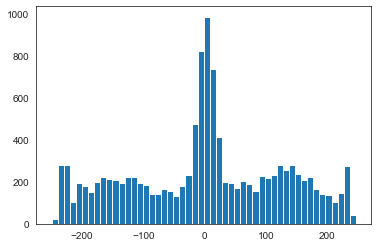

In [60]:
plt.hist(drop_columns_Curry['LOC_X'], bins=50)
plt.show()

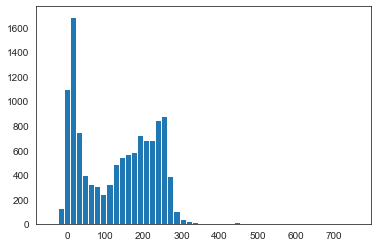

In [61]:
plt.hist(drop_columns_Curry['LOC_Y'], bins=50)
plt.show()

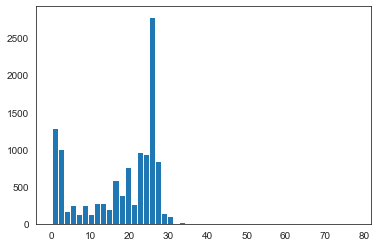

In [62]:
plt.hist(drop_columns_Curry['SHOT_DISTANCE'], bins=50)
plt.show()

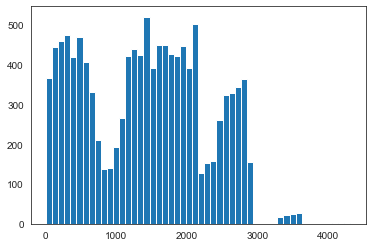

In [63]:
plt.hist(drop_columns_Curry['Seconds Into Game'], bins=50)
plt.show()

#### Using Spearman since three out of the four numeric variables don't appear to be normally distributed

In [66]:
drop_columns_Curry[['SHOT_DISTANCE', 'LOC_X', 'LOC_Y',
                    'Seconds Into Game']].corr(method='spearman')

,SHOT_DISTANCE,LOC_X,LOC_Y,Seconds Into Game
SHOT_DISTANCE,1.000000,0.005644,0.831197,0.021821
LOC_X,0.005644,1.000000,0.044326,0.044204
LOC_Y,0.831197,0.044326,1.000000,0.032823
Seconds Into Game,0.021821,0.044204,0.032823,1.000000


In [67]:
skew_of_numerical = drop_columns_Curry[[
    'SHOT_DISTANCE', 'LOC_X', 'LOC_Y', 'Seconds Into Game']].skew()
skew_of_numerical

SHOT_DISTANCE       -0.206617
LOC_X               -0.081218
LOC_Y                0.454312
Seconds Into Game    0.083814
dtype: float64

#### Running Thiel's U on categorical variables


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


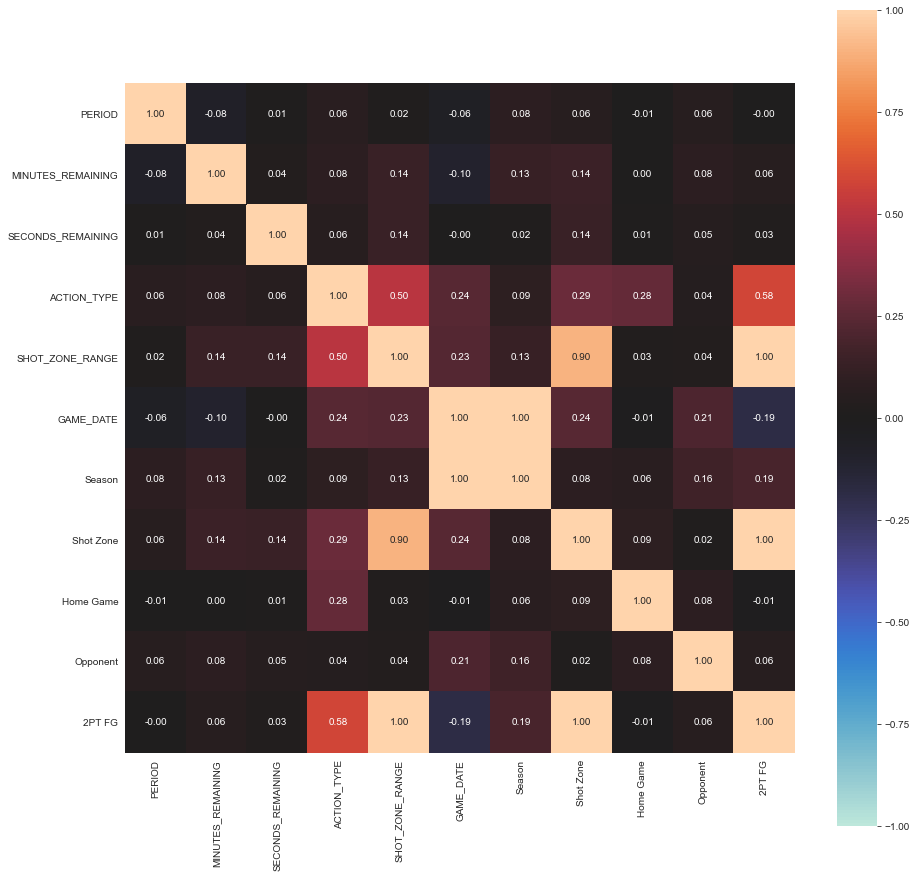

{'corr':                      PERIOD  MINUTES_REMAINING  SECONDS_REMAINING  \
 PERIOD             1.000000          -0.077965           0.008003   
 MINUTES_REMAINING -0.077965           1.000000           0.037451   
 SECONDS_REMAINING  0.008003           0.037451           1.000000   
 ACTION_TYPE        0.064843           0.082395           0.055603   
 SHOT_ZONE_RANGE    0.023311           0.139267           0.135187   
 GAME_DATE         -0.060903          -0.099335          -0.004483   
 Season             0.079853           0.131118           0.023051   
 Shot Zone          0.057167           0.144665           0.136295   
 Home Game         -0.005323           0.000904           0.010148   
 Opponent           0.059876           0.084648           0.049401   
 2PT FG            -0.004349           0.056439           0.026368   
 
                    ACTION_TYPE  SHOT_ZONE_RANGE  GAME_DATE    Season  \
 PERIOD                0.064843         0.023311  -0.060903  0.079853   
 MIN

In [69]:
associations(drop_columns_Curry[['PERIOD', 'MINUTES_REMAINING',
                                 'SECONDS_REMAINING', 'ACTION_TYPE',
                                 'SHOT_ZONE_RANGE', 'GAME_DATE', 'Season',
                                'Shot Zone', 'Home Game', 'Opponent',
                                 '2PT FG']], figsize=(15, 15))

In [70]:
pd.crosstab(drop_columns_Curry['2PT FG'], drop_columns_Curry['SHOT_ZONE_RANGE'])

SHOT_ZONE_RANGE,16-24 ft.,24+ ft.,8-16 ft.,Back Court Shot,Less Than 8 ft.
2PT FG,,,,,
0,0,5656,0,80,0
1,2199,0,1133,0,2860


In [71]:
pd.crosstab(drop_columns_Curry['2PT FG'], drop_columns_Curry['Shot Zone'])

Shot Zone,Above the Break 3 on Back Court(BC),Above the Break 3 on Center(C),Above the Break 3 on Left Side Center(LC),Above the Break 3 on Right Side Center(RC),Backcourt on Back Court(BC),In The Paint (Non-RA) on Center(C),In The Paint (Non-RA) on Left Side(L),In The Paint (Non-RA) on Right Side(R),Left Corner 3 on Left Side(L),Mid-Range on Center(C),Mid-Range on Left Side Center(LC),Mid-Range on Left Side(L),Mid-Range on Right Side Center(RC),Mid-Range on Right Side(R),Restricted Area on Center(C),Right Corner 3 on Right Side(R)
2PT FG,,,,,,,,,,,,,,,,
0,4,1330,1663,1792,76,0,0,0,509,0,0,0,0,0,0,362
1,0,0,0,0,0,940,54,58,0,535,577,514,703,511,2300,0


In [72]:
pd.crosstab(drop_columns_Curry['SHOT_ZONE_RANGE'], drop_columns_Curry['Shot Zone'])

Shot Zone,Above the Break 3 on Back Court(BC),Above the Break 3 on Center(C),Above the Break 3 on Left Side Center(LC),Above the Break 3 on Right Side Center(RC),Backcourt on Back Court(BC),In The Paint (Non-RA) on Center(C),In The Paint (Non-RA) on Left Side(L),In The Paint (Non-RA) on Right Side(R),Left Corner 3 on Left Side(L),Mid-Range on Center(C),Mid-Range on Left Side Center(LC),Mid-Range on Left Side(L),Mid-Range on Right Side Center(RC),Mid-Range on Right Side(R),Restricted Area on Center(C),Right Corner 3 on Right Side(R)
SHOT_ZONE_RANGE,,,,,,,,,,,,,,,,
16-24 ft.,0,0,0,0,0,0,0,0,0,429,577,256,703,234,0,0
24+ ft.,0,1330,1663,1792,0,0,0,0,509,0,0,0,0,0,0,362
8-16 ft.,0,0,0,0,0,380,54,58,0,106,0,258,0,277,0,0
Back Court Shot,4,0,0,0,76,0,0,0,0,0,0,0,0,0,0,0
Less Than 8 ft.,0,0,0,0,0,560,0,0,0,0,0,0,0,0,2300,0


### Deciding on columns that will be used in the data analysis

In [73]:
drop_columns_Curry.columns.tolist()

['GAME_ID',
 'GAME_EVENT_ID',
 'PERIOD',
 'MINUTES_REMAINING',
 'SECONDS_REMAINING',
 'EVENT_TYPE',
 'ACTION_TYPE',
 'SHOT_TYPE',
 'SHOT_ZONE_BASIC',
 'SHOT_ZONE_AREA',
 'SHOT_ZONE_RANGE',
 'SHOT_DISTANCE',
 'LOC_X',
 'LOC_Y',
 'SHOT_MADE_FLAG',
 'GAME_DATE',
 'HTM',
 'VTM',
 'Seconds Into Game',
 'Season',
 'Shot Zone',
 'Home Game',
 'Opponent',
 '2PT FG']

In [75]:
'''
Why I don't need specific columns:
    don't need EVENT_TYPE because SHOT_MADE_FLAG is the binary version
    Seconds Into Game condenses period/minutes/seconds
    SHOT_TYPE is now 2PT FG
    SHOT_ZONE_BASIC and SHOT_ZONE_AREA SHOT_ZONEs are now condensed
    HTM and VTM have been parsed
    GAME_ID provides the same info as GAME_DATE
    GAME_EVENT_ID is only when the event occurred in the game
    2PT_FG can be explained by both SHOT_ZONE_RANGE and Shot Zone
'''
x_columns_Curry = drop_columns_Curry.drop(['EVENT_TYPE', 'SHOT_TYPE',
                                           'SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA',
                                           'HTM', 'VTM', 'GAME_ID',
                                           'GAME_EVENT_ID', 'SHOT_MADE_FLAG',
                                          '2PT FG'],
                                          axis=1)
y_column_Curry = drop_columns_Curry['SHOT_MADE_FLAG']
print(x_columns_Curry.shape)
print(y_column_Curry.shape)
print(x_columns_Curry.columns.tolist())

(11928, 14)
(11928,)
['PERIOD', 'MINUTES_REMAINING', 'SECONDS_REMAINING', 'ACTION_TYPE', 'SHOT_ZONE_RANGE', 'SHOT_DISTANCE', 'LOC_X', 'LOC_Y', 'GAME_DATE', 'Seconds Into Game', 'Season', 'Shot Zone', 'Home Game', 'Opponent']


In [76]:
x_columns_Curry.head(5)

,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,ACTION_TYPE,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,GAME_DATE,Seconds Into Game,Season,Shot Zone,Home Game,Opponent
0,1,11,25,Jump Shot,24+ ft.,26,99,249,20091028,35,2009,Above the Break 3 on Right Side Center(RC),1,HOU
1,1,9,31,Step Back Jump shot,16-24 ft.,18,-122,145,20091028,149,2009,Mid-Range on Left Side Center(LC),1,HOU
2,1,6,2,Jump Shot,8-16 ft.,14,-60,129,20091028,358,2009,In The Paint (Non-RA) on Center(C),1,HOU
3,2,9,49,Jump Shot,16-24 ft.,19,-172,82,20091028,851,2009,Mid-Range on Left Side(L),1,HOU
4,2,2,19,Jump Shot,16-24 ft.,16,-68,148,20091028,1301,2009,Mid-Range on Left Side Center(LC),1,HOU


# Splitting The Data 

In [82]:
X_train, X_test, Y_train, Y_test = train_test_split(x_columns_Curry,
                                                    y_column_Curry,
                                                    test_size=0.25,
                                                    shuffle=True, random_state=1)

In [83]:
def confirming_stratified_split(y):
    '''examining the number of makes and misses for the training and test sets
    to confirm they resemble the accuracy of Curry's makes and misses in his
    career (~52% missed, ~48% made)

    Args:
        y (Series): y values for the trianing set or the test set that's
        composed of 0 (misses) and 1 (makes)

    Returns:
        misses (float): about how much of the data set is composed of 0
        makes (float): about how much of the data set is composed of 1
    '''
    value_counts = y.value_counts()
    missed_shots_percent = value_counts[0] / value_counts.sum(axis=0)
    made_shots_percent = value_counts[1] / value_counts.sum(axis=0)
    misses = round(missed_shots_percent, 3)
    makes = round(made_shots_percent, 3)
    return misses, makes

In [94]:
'''
examining training set
'''
train_misses, train_makes = confirming_stratified_split(Y_train)
print("In the training set, Curry missed {} of his shots and made {} of "
      "his shots".format(train_misses, train_makes))
test_misses, test_makes = confirming_stratified_split(Y_test)
print("In the test set, Curry missed {} of his shots and made {} of "
      "his shots".format(test_misses, test_makes))

In the training set, Curry missed 0.526 of his shots and made 0.474 of his shots
In the test set, Curry missed 0.516 of his shots and made 0.484 of his shots


In [95]:
def unique_features(dataset, df_name):
    '''Checking the number of unique values in the four large category columns for train or test sets

    Args:
        column_list (list): the columns to examine
        dataset (DataFrame): either the independent variables for the train or test sets
        df_name (str): identifying whether it's the train or test set
    '''
    for i in dataset.columns.tolist():
        print("The column {} has {} unique features in the {} set".format(
            i, len(dataset[i].unique()), df_name))
    print('\n')


unique_features(X_train, 'train')
unique_features(X_test, 'test')

2:80: E501 line too long (97 > 79 characters)
6:80: E501 line too long (88 > 79 characters)


The column PERIOD has 6 unique features in the train set
The column MINUTES_REMAINING has 12 unique features in the train set
The column SECONDS_REMAINING has 60 unique features in the train set
The column ACTION_TYPE has 50 unique features in the train set
The column SHOT_ZONE_RANGE has 5 unique features in the train set
The column SHOT_DISTANCE has 66 unique features in the train set
The column LOC_X has 483 unique features in the train set
The column LOC_Y has 416 unique features in the train set
The column GAME_DATE has 697 unique features in the train set
The column Seconds Into Game has 2660 unique features in the train set
The column Season has 12 unique features in the train set
The column Shot Zone has 16 unique features in the train set
The column Home Game has 2 unique features in the train set
The column Opponent has 31 unique features in the train set


The column PERIOD has 6 unique features in the test set
The column MINUTES_REMAINING has 12 unique features in the test s

In [96]:
print(X_train.columns.tolist())
print(X_test.columns.tolist())

['PERIOD', 'MINUTES_REMAINING', 'SECONDS_REMAINING', 'ACTION_TYPE', 'SHOT_ZONE_RANGE', 'SHOT_DISTANCE', 'LOC_X', 'LOC_Y', 'GAME_DATE', 'Seconds Into Game', 'Season', 'Shot Zone', 'Home Game', 'Opponent']
['PERIOD', 'MINUTES_REMAINING', 'SECONDS_REMAINING', 'ACTION_TYPE', 'SHOT_ZONE_RANGE', 'SHOT_DISTANCE', 'LOC_X', 'LOC_Y', 'GAME_DATE', 'Seconds Into Game', 'Season', 'Shot Zone', 'Home Game', 'Opponent']


# Machine Learning Analysis

## Catboost

In [98]:
'''
Obtaining the indices for the categorical features
'''

cat_col_names = ['PERIOD', 'MINUTES_REMAINING', 'SECONDS_REMAINING',
                 'ACTION_TYPE', 'SHOT_ZONE_RANGE', 'GAME_DATE', 'Season',
                 'Shot Zone', 'Home Game', 'Opponent']

cat_features = []
for col_name in X_train.columns:
    if col_name in cat_col_names:
        cat_features.append(X_train.columns.get_loc(col_name))

print(cat_features)

[0, 1, 2, 3, 4, 8, 10, 11, 12, 13]


In [102]:
'''
performing default CatBoost to see what the potential results are
'''

model = CatBoostClassifier(
    random_seed=63,
    custom_loss=['Accuracy'],
    early_stopping_rounds=50,
)


In [106]:
model.fit(
    X_train, Y_train,
    cat_features=cat_features,
    eval_set=(X_test, Y_test),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [107]:
model.best_score_

{'learn': {'Accuracy': 0.7008718980549966, 'Logloss': 0.5614344794852018},
 'validation': {'Accuracy': 0.6680080482897385, 'Logloss': 0.6102594287064044}}

### CatBoost Cross Validation (CV)

In [108]:
# setting the cross validation parameters
cv_params = model.get_params()
cv_params.update({
    'loss_function': 'Logloss'
})
cv_params

{'random_seed': 63,
 'custom_loss': ['Accuracy'],
 'early_stopping_rounds': 50,
 'loss_function': 'Logloss'}

In [110]:
%%time
cv_data = cv(
    Pool(X_train, Y_train, cat_features=cat_features),
    cv_params,
    plot=True,
    verbose=False,
    stratified=True,
    fold_count=10
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Stopped by overfitting detector  (50 iterations wait)
CPU times: user 7min 9s, sys: 1min 12s, total: 8min 22s
Wall time: 1min 57s


In [111]:
print('Best validation accuracy score: {:.4f}±{:.4f} on step {}'.format(
    np.max(cv_data['test-Accuracy-mean']),
    cv_data['test-Accuracy-std'][np.argmax(cv_data['test-Accuracy-mean'])],
    np.argmax(cv_data['test-Accuracy-mean'])
))

Best validation accuracy score: 0.6603±0.0118 on step 166


### CatBoost Bayesian Optimization

In [114]:
def hyperopt_objective(params):
    bayesian_model = CatBoostClassifier(
        l2_leaf_reg=int(params['l2_leaf_reg']),
        learning_rate=params['learning_rate'],
        depth=params['depth'],
        early_stopping_rounds=50,
        eval_metric='Accuracy',
        random_seed=63,
        loss_function='Logloss',
    )

    cv_data = cv(
        Pool(X_train, Y_train, cat_features=cat_features),
        bayesian_model.get_params(), stratified=True, fold_count=10
    )
    best_accuracy = np.max(cv_data['test-Accuracy-mean'])

    return 1 - best_accuracy  # as hyperopt minimises

In [116]:
from numpy.random import RandomState

params_space = {
    'l2_leaf_reg': hyperopt.hp.qloguniform('l2_leaf_reg', 0, 2, 1),
    'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-3, 5e-1),
    'depth': hyperopt.hp.choice('depth', [5,  2,  3,  4,  1,  6,  7,  8,
                                          9, 10, 11, 12, 13])
}

trials = hyperopt.Trials()

In [117]:
%%time
# the higher the max_evals, the better the result may be
#  By default, tpe performs the first 20 evaluations randomly as a warm up to get an idea of where to start.
best = hyperopt.fmin(
    hyperopt_objective,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=RandomState(123)
)

0:	learn: 0.6605435	test: 0.6564954	best: 0.6564954 (0)	total: 319ms	remaining: 5m 18s

1:	learn: 0.6619346	test: 0.6591782	best: 0.6591782 (1)	total: 519ms	remaining: 4m 18s

2:	learn: 0.6637355	test: 0.6591779	best: 0.6591782 (1)	total: 720ms	remaining: 3m 59s

3:	learn: 0.6655240	test: 0.6605206	best: 0.6605206 (3)	total: 1.02s	remaining: 4m 14s

4:	learn: 0.6667536	test: 0.6611918	best: 0.6611918 (4)	total: 1.25s	remaining: 4m 9s

5:	learn: 0.6678341	test: 0.6601843	best: 0.6611918 (4)	total: 1.46s	remaining: 4m 1s

6:	learn: 0.6696599	test: 0.6587319	best: 0.6611918 (4)	total: 1.7s	remaining: 4m 1s

7:	learn: 0.6712124	test: 0.6586200	best: 0.6611918 (4)	total: 1.96s	remaining: 4m 2s

8:	learn: 0.6731996	test: 0.6582841	best: 0.6611918 (4)	total: 2.2s	remaining: 4m 2s

9:	learn: 0.6748515	test: 0.6578356	best: 0.6611918 (4)	total: 2.41s	remaining: 3m 58s

10:	learn: 0.6762550	test: 0.6577238	best: 0.6611918 (4)	total: 2.63s	remaining: 3m 56s

11:	learn: 0.6775840	test: 0.6585060	b

36:	learn: 0.6745410	test: 0.6596211	best: 0.6621958 (24)	total: 5.22s	remaining: 2m 15s

37:	learn: 0.6752986	test: 0.6598449	best: 0.6621958 (24)	total: 5.34s	remaining: 2m 15s

38:	learn: 0.6759569	test: 0.6586158	best: 0.6621958 (24)	total: 5.46s	remaining: 2m 14s

39:	learn: 0.6767021	test: 0.6593985	best: 0.6621958 (24)	total: 5.59s	remaining: 2m 14s

40:	learn: 0.6775591	test: 0.6596222	best: 0.6621958 (24)	total: 5.71s	remaining: 2m 13s

41:	learn: 0.6779690	test: 0.6599569	best: 0.6621958 (24)	total: 5.83s	remaining: 2m 13s

42:	learn: 0.6791116	test: 0.6600679	best: 0.6621958 (24)	total: 5.95s	remaining: 2m 12s

43:	learn: 0.6794718	test: 0.6606266	best: 0.6621958 (24)	total: 6.07s	remaining: 2m 11s

44:	learn: 0.6799686	test: 0.6614097	best: 0.6621958 (24)	total: 6.19s	remaining: 2m 11s

45:	learn: 0.6807138	test: 0.6611861	best: 0.6621958 (24)	total: 6.36s	remaining: 2m 11s

46:	learn: 0.6813100	test: 0.6607393	best: 0.6621958 (24)	total: 6.51s	remaining: 2m 11s

47:	learn:

51:	learn: 0.9973545	test: 0.6281073	best: 0.6573895 (2)	total: 39.5s	remaining: 11m 59s

Stopped by overfitting detector  (50 iterations wait)                            

52:	learn: 0.9977768	test: 0.6259844	best: 0.6573895 (2)	total: 40.4s	remaining: 12m 1s

0:	learn: 0.6635989	test: 0.6544842	best: 0.6544842 (0)	total: 520ms	remaining: 8m 39s

1:	learn: 0.6682814	test: 0.6544837	best: 0.6544842 (0)	total: 1.04s	remaining: 8m 41s

2:	learn: 0.6717466	test: 0.6564952	best: 0.6564952 (2)	total: 1.45s	remaining: 8m 3s

3:	learn: 0.6736717	test: 0.6544833	best: 0.6564952 (2)	total: 1.75s	remaining: 7m 15s

4:	learn: 0.6778574	test: 0.6558243	best: 0.6564952 (2)	total: 2.24s	remaining: 7m 26s

5:	learn: 0.6814094	test: 0.6551547	best: 0.6564952 (2)	total: 2.62s	remaining: 7m 14s

6:	learn: 0.6856821	test: 0.6550431	best: 0.6564952 (2)	total: 3.18s	remaining: 7m 30s

7:	learn: 0.6893213	test: 0.6550436	best: 0.6564952 (2)	total: 3.74s	remaining: 7m 44s

8:	learn: 0.6936560	test: 0.6558257

35:	learn: 0.9828849	test: 0.6373790	best: 0.6588405 (5)	total: 35.7s	remaining: 15m 57s

36:	learn: 0.9853193	test: 0.6376013	best: 0.6588405 (5)	total: 36.9s	remaining: 16m

37:	learn: 0.9873811	test: 0.6321242	best: 0.6588405 (5)	total: 38.1s	remaining: 16m 3s

38:	learn: 0.9897906	test: 0.6350312	best: 0.6588405 (5)	total: 39s	remaining: 16m 1s

39:	learn: 0.9915667	test: 0.6337992	best: 0.6588405 (5)	total: 40.1s	remaining: 16m 2s

40:	learn: 0.9929578	test: 0.6345838	best: 0.6588405 (5)	total: 41.1s	remaining: 16m

41:	learn: 0.9948084	test: 0.6348064	best: 0.6588405 (5)	total: 42s	remaining: 15m 58s

42:	learn: 0.9961622	test: 0.6343612	best: 0.6588405 (5)	total: 43s	remaining: 15m 57s

43:	learn: 0.9969322	test: 0.6338035	best: 0.6588405 (5)	total: 44.1s	remaining: 15m 57s

44:	learn: 0.9977768	test: 0.6363720	best: 0.6588405 (5)	total: 45s	remaining: 15m 55s

45:	learn: 0.9982612	test: 0.6355910	best: 0.6588405 (5)	total: 46s	remaining: 15m 53s

46:	learn: 0.9985841	test: 0.63

70:	learn: 0.6590283	test: 0.6609663	best: 0.6615248 (54)	total: 4.24s	remaining: 55.4s

71:	learn: 0.6590531	test: 0.6605195	best: 0.6615248 (54)	total: 4.3s	remaining: 55.4s

72:	learn: 0.6589041	test: 0.6604080	best: 0.6615248 (54)	total: 4.36s	remaining: 55.4s

73:	learn: 0.6589165	test: 0.6604080	best: 0.6615248 (54)	total: 4.41s	remaining: 55.2s

74:	learn: 0.6590034	test: 0.6604080	best: 0.6615248 (54)	total: 4.47s	remaining: 55.2s

75:	learn: 0.6590283	test: 0.6606312	best: 0.6615248 (54)	total: 4.53s	remaining: 55.1s

76:	learn: 0.6590531	test: 0.6609671	best: 0.6615248 (54)	total: 4.58s	remaining: 55s

77:	learn: 0.6590904	test: 0.6608554	best: 0.6615248 (54)	total: 4.64s	remaining: 54.9s

78:	learn: 0.6590904	test: 0.6605197	best: 0.6615248 (54)	total: 4.7s	remaining: 54.8s

79:	learn: 0.6590158	test: 0.6611906	best: 0.6615248 (54)	total: 4.76s	remaining: 54.7s

80:	learn: 0.6590779	test: 0.6608554	best: 0.6615248 (54)	total: 4.81s	remaining: 54.6s

81:	learn: 0.6591649	test

161:	learn: 0.6597610	test: 0.6619733	best: 0.6624200 (139)	total: 9.45s	remaining: 48.9s

162:	learn: 0.6598107	test: 0.6620852	best: 0.6624200 (139)	total: 9.56s	remaining: 49.1s

163:	learn: 0.6596989	test: 0.6618617	best: 0.6624200 (139)	total: 9.68s	remaining: 49.3s

164:	learn: 0.6597362	test: 0.6618616	best: 0.6624200 (139)	total: 9.78s	remaining: 49.5s

165:	learn: 0.6598107	test: 0.6618617	best: 0.6624200 (139)	total: 9.89s	remaining: 49.7s

166:	learn: 0.6597238	test: 0.6617500	best: 0.6624200 (139)	total: 9.98s	remaining: 49.8s

167:	learn: 0.6597238	test: 0.6619735	best: 0.6624200 (139)	total: 10.1s	remaining: 49.9s

168:	learn: 0.6597983	test: 0.6617499	best: 0.6624200 (139)	total: 10.3s	remaining: 50.5s

169:	learn: 0.6597859	test: 0.6614147	best: 0.6624200 (139)	total: 10.3s	remaining: 50.5s

170:	learn: 0.6598355	test: 0.6614146	best: 0.6624200 (139)	total: 10.4s	remaining: 50.5s

171:	learn: 0.6597362	test: 0.6613028	best: 0.6624200 (139)	total: 10.5s	remaining: 50.6s


8:	learn: 0.6595748	test: 0.6581715	best: 0.6602960 (1)	total: 1.07s	remaining: 1m 57s

9:	learn: 0.6599847	test: 0.6582831	best: 0.6602960 (1)	total: 1.18s	remaining: 1m 57s

10:	learn: 0.6608789	test: 0.6591774	best: 0.6602960 (1)	total: 1.3s	remaining: 1m 56s

11:	learn: 0.6611770	test: 0.6591775	best: 0.6602960 (1)	total: 1.4s	remaining: 1m 55s

12:	learn: 0.6615620	test: 0.6585070	best: 0.6602960 (1)	total: 1.51s	remaining: 1m 54s

13:	learn: 0.6616117	test: 0.6577245	best: 0.6602960 (1)	total: 1.61s	remaining: 1m 53s

14:	learn: 0.6618352	test: 0.6582836	best: 0.6602960 (1)	total: 1.73s	remaining: 1m 53s

15:	learn: 0.6621085	test: 0.6576131	best: 0.6602960 (1)	total: 1.84s	remaining: 1m 53s

16:	learn: 0.6623693	test: 0.6575011	best: 0.6602960 (1)	total: 1.95s	remaining: 1m 52s

17:	learn: 0.6626425	test: 0.6573892	best: 0.6602960 (1)	total: 2.05s	remaining: 1m 51s

18:	learn: 0.6628537	test: 0.6578364	best: 0.6602960 (1)	total: 2.16s	remaining: 1m 51s

19:	learn: 0.6633008	test

47:	learn: 0.6973818	test: 0.6604087	best: 0.6604087 (47)	total: 6.63s	remaining: 2m 11s

48:	learn: 0.6984500	test: 0.6595137	best: 0.6604087 (47)	total: 6.79s	remaining: 2m 11s

49:	learn: 0.6987729	test: 0.6581726	best: 0.6604087 (47)	total: 6.96s	remaining: 2m 12s

50:	learn: 0.7003628	test: 0.6587324	best: 0.6604087 (47)	total: 7.11s	remaining: 2m 12s

51:	learn: 0.7016669	test: 0.6585082	best: 0.6604087 (47)	total: 7.26s	remaining: 2m 12s

52:	learn: 0.7025363	test: 0.6602967	best: 0.6604087 (47)	total: 7.42s	remaining: 2m 12s

53:	learn: 0.7031076	test: 0.6592898	best: 0.6604087 (47)	total: 7.55s	remaining: 2m 12s

54:	learn: 0.7039025	test: 0.6569414	best: 0.6604087 (47)	total: 7.68s	remaining: 2m 12s

55:	learn: 0.7047718	test: 0.6570524	best: 0.6604087 (47)	total: 7.82s	remaining: 2m 11s

56:	learn: 0.7059269	test: 0.6566060	best: 0.6604087 (47)	total: 7.95s	remaining: 2m 11s

57:	learn: 0.7066349	test: 0.6572775	best: 0.6604087 (47)	total: 8.09s	remaining: 2m 11s

58:	learn:

39:	learn: 0.9977023	test: 0.6236351	best: 0.6566045 (3)	total: 37.7s	remaining: 15m 4s

40:	learn: 0.9983978	test: 0.6263171	best: 0.6566045 (3)	total: 38.8s	remaining: 15m 7s

41:	learn: 0.9989195	test: 0.6271006	best: 0.6566045 (3)	total: 39.9s	remaining: 15m 10s

42:	learn: 0.9992051	test: 0.6262053	best: 0.6566045 (3)	total: 40.9s	remaining: 15m 9s

43:	learn: 0.9993790	test: 0.6212877	best: 0.6566045 (3)	total: 41.8s	remaining: 15m 9s

44:	learn: 0.9994659	test: 0.6257580	best: 0.6566045 (3)	total: 43s	remaining: 15m 12s

45:	learn: 0.9995653	test: 0.6248641	best: 0.6566045 (3)	total: 44s	remaining: 15m 12s

46:	learn: 0.9997019	test: 0.6253108	best: 0.6566045 (3)	total: 44.9s	remaining: 15m 11s

47:	learn: 0.9997764	test: 0.6255355	best: 0.6566045 (3)	total: 45.9s	remaining: 15m 10s

48:	learn: 0.9998385	test: 0.6277704	best: 0.6566045 (3)	total: 46.9s	remaining: 15m 9s

49:	learn: 0.9999006	test: 0.6279941	best: 0.6566045 (3)	total: 47.9s	remaining: 15m 9s

50:	learn: 0.9999255

20:	learn: 0.6605187	test: 0.6604076	best: 0.6607439 (1)	total: 3.6s	remaining: 2m 47s

21:	learn: 0.6604814	test: 0.6604080	best: 0.6607439 (1)	total: 3.81s	remaining: 2m 49s

22:	learn: 0.6606677	test: 0.6601844	best: 0.6607439 (1)	total: 3.99s	remaining: 2m 49s

23:	learn: 0.6606553	test: 0.6600724	best: 0.6607439 (1)	total: 4.18s	remaining: 2m 50s

24:	learn: 0.6607547	test: 0.6604079	best: 0.6607439 (1)	total: 4.4s	remaining: 2m 51s

25:	learn: 0.6608168	test: 0.6600723	best: 0.6607439 (1)	total: 4.59s	remaining: 2m 51s

26:	learn: 0.6608416	test: 0.6602960	best: 0.6607439 (1)	total: 4.75s	remaining: 2m 51s

27:	learn: 0.6606181	test: 0.6598488	best: 0.6607439 (1)	total: 4.91s	remaining: 2m 50s

28:	learn: 0.6607298	test: 0.6600728	best: 0.6607439 (1)	total: 5.1s	remaining: 2m 50s

29:	learn: 0.6607174	test: 0.6604080	best: 0.6607439 (1)	total: 5.28s	remaining: 2m 50s

30:	learn: 0.6607050	test: 0.6601846	best: 0.6607439 (1)	total: 5.46s	remaining: 2m 50s

31:	learn: 0.6606553	tes

59:	learn: 0.6694984	test: 0.6608548	best: 0.6616379 (47)	total: 11.3s	remaining: 2m 57s

60:	learn: 0.6697343	test: 0.6610784	best: 0.6616379 (47)	total: 11.5s	remaining: 2m 57s

61:	learn: 0.6699579	test: 0.6611902	best: 0.6616379 (47)	total: 11.7s	remaining: 2m 57s

62:	learn: 0.6700945	test: 0.6608552	best: 0.6616379 (47)	total: 11.9s	remaining: 2m 57s

63:	learn: 0.6702560	test: 0.6609669	best: 0.6616379 (47)	total: 12.1s	remaining: 2m 56s

64:	learn: 0.6704796	test: 0.6610791	best: 0.6616379 (47)	total: 12.3s	remaining: 2m 57s

65:	learn: 0.6707155	test: 0.6602966	best: 0.6616379 (47)	total: 12.5s	remaining: 2m 56s

66:	learn: 0.6707901	test: 0.6606318	best: 0.6616379 (47)	total: 12.7s	remaining: 2m 56s

67:	learn: 0.6708025	test: 0.6614147	best: 0.6616379 (47)	total: 12.9s	remaining: 2m 56s

68:	learn: 0.6707528	test: 0.6613026	best: 0.6616379 (47)	total: 13.1s	remaining: 2m 56s

69:	learn: 0.6708025	test: 0.6609675	best: 0.6616379 (47)	total: 13.3s	remaining: 2m 56s

70:	learn:

52:	learn: 0.6738207	test: 0.6572780	best: 0.6601843 (7)	total: 7.47s	remaining: 2m 13s

53:	learn: 0.6740940	test: 0.6571666	best: 0.6601843 (7)	total: 7.61s	remaining: 2m 13s

54:	learn: 0.6743051	test: 0.6567192	best: 0.6601843 (7)	total: 7.74s	remaining: 2m 13s

55:	learn: 0.6747149	test: 0.6575019	best: 0.6601843 (7)	total: 7.88s	remaining: 2m 12s

56:	learn: 0.6752242	test: 0.6579490	best: 0.6601843 (7)	total: 8s	remaining: 2m 12s

Stopped by overfitting detector  (50 iterations wait)                             

57:	learn: 0.6754353	test: 0.6572777	best: 0.6601843 (7)	total: 8.14s	remaining: 2m 12s

0:	learn: 0.6750374	test: 0.6502345	best: 0.6502345 (0)	total: 1.26s	remaining: 21m 1s

1:	learn: 0.6966733	test: 0.6560457	best: 0.6560457 (1)	total: 3s	remaining: 24m 58s

2:	learn: 0.7166572	test: 0.6524650	best: 0.6560457 (1)	total: 4.76s	remaining: 26m 23s

3:	learn: 0.7335984	test: 0.6522432	best: 0.6560457 (1)	total: 6.36s	remaining: 26m 23s

4:	learn: 0.7536950	test: 0.65090

31:	learn: 0.6594630	test: 0.6592902	best: 0.6610775 (11)	total: 2.7s	remaining: 1m 21s

32:	learn: 0.6593760	test: 0.6587316	best: 0.6610775 (11)	total: 2.78s	remaining: 1m 21s

33:	learn: 0.6595499	test: 0.6587317	best: 0.6610775 (11)	total: 2.85s	remaining: 1m 21s

34:	learn: 0.6597362	test: 0.6587317	best: 0.6610775 (11)	total: 2.92s	remaining: 1m 20s

35:	learn: 0.6599598	test: 0.6589552	best: 0.6610775 (11)	total: 3s	remaining: 1m 20s

36:	learn: 0.6600964	test: 0.6583959	best: 0.6610775 (11)	total: 3.07s	remaining: 1m 20s

37:	learn: 0.6604442	test: 0.6582837	best: 0.6610775 (11)	total: 3.14s	remaining: 1m 19s

38:	learn: 0.6602703	test: 0.6581717	best: 0.6610775 (11)	total: 3.23s	remaining: 1m 19s

39:	learn: 0.6604442	test: 0.6580600	best: 0.6610775 (11)	total: 3.33s	remaining: 1m 19s

40:	learn: 0.6608168	test: 0.6579479	best: 0.6610775 (11)	total: 3.41s	remaining: 1m 19s

41:	learn: 0.6608292	test: 0.6576126	best: 0.6610775 (11)	total: 3.48s	remaining: 1m 19s

42:	learn: 0.6

6:	learn: 0.6570535	test: 0.6589548	best: 0.6608549 (2)	total: 612ms	remaining: 1m 26s

7:	learn: 0.6575503	test: 0.6589550	best: 0.6608549 (2)	total: 684ms	remaining: 1m 24s

8:	learn: 0.6575999	test: 0.6592904	best: 0.6608549 (2)	total: 754ms	remaining: 1m 22s

9:	learn: 0.6573143	test: 0.6595139	best: 0.6608549 (2)	total: 832ms	remaining: 1m 22s

10:	learn: 0.6575751	test: 0.6590668	best: 0.6608549 (2)	total: 961ms	remaining: 1m 26s

11:	learn: 0.6577862	test: 0.6595139	best: 0.6608549 (2)	total: 1.04s	remaining: 1m 25s

12:	learn: 0.6578235	test: 0.6594021	best: 0.6608549 (2)	total: 1.13s	remaining: 1m 25s

13:	learn: 0.6579229	test: 0.6588425	best: 0.6608549 (2)	total: 1.2s	remaining: 1m 24s

14:	learn: 0.6578732	test: 0.6589542	best: 0.6608549 (2)	total: 1.27s	remaining: 1m 23s

15:	learn: 0.6578856	test: 0.6590661	best: 0.6608549 (2)	total: 1.35s	remaining: 1m 22s

16:	learn: 0.6579601	test: 0.6590661	best: 0.6608549 (2)	total: 1.42s	remaining: 1m 22s

17:	learn: 0.6580222	test:

16:	learn: 0.6568796	test: 0.6591797	best: 0.6608554 (3)	total: 1.11s	remaining: 1m 4s

17:	learn: 0.6570659	test: 0.6590677	best: 0.6608554 (3)	total: 1.16s	remaining: 1m 3s

18:	learn: 0.6568920	test: 0.6594029	best: 0.6608554 (3)	total: 1.22s	remaining: 1m 2s

19:	learn: 0.6569168	test: 0.6594029	best: 0.6608554 (3)	total: 1.27s	remaining: 1m 2s

20:	learn: 0.6568547	test: 0.6595146	best: 0.6608554 (3)	total: 1.33s	remaining: 1m 2s

21:	learn: 0.6569541	test: 0.6592912	best: 0.6608554 (3)	total: 1.42s	remaining: 1m 3s

22:	learn: 0.6570038	test: 0.6597381	best: 0.6608554 (3)	total: 1.49s	remaining: 1m 3s

23:	learn: 0.6570659	test: 0.6597381	best: 0.6608554 (3)	total: 1.55s	remaining: 1m 3s

24:	learn: 0.6571776	test: 0.6598498	best: 0.6608554 (3)	total: 1.62s	remaining: 1m 3s

25:	learn: 0.6571776	test: 0.6596260	best: 0.6608554 (3)	total: 1.67s	remaining: 1m 2s

26:	learn: 0.6571901	test: 0.6597377	best: 0.6608554 (3)	total: 1.74s	remaining: 1m 2s

27:	learn: 0.6571528	test: 0.659

108:	learn: 0.6588793	test: 0.6616380	best: 0.6629797 (97)	total: 6.45s	remaining: 52.7s

109:	learn: 0.6588917	test: 0.6617500	best: 0.6629797 (97)	total: 6.5s	remaining: 52.6s

110:	learn: 0.6587426	test: 0.6614147	best: 0.6629797 (97)	total: 6.55s	remaining: 52.5s

111:	learn: 0.6589041	test: 0.6615264	best: 0.6629797 (97)	total: 6.61s	remaining: 52.4s

112:	learn: 0.6589041	test: 0.6616380	best: 0.6629797 (97)	total: 6.66s	remaining: 52.3s

113:	learn: 0.6588420	test: 0.6619732	best: 0.6629797 (97)	total: 6.72s	remaining: 52.2s

114:	learn: 0.6588544	test: 0.6620852	best: 0.6629797 (97)	total: 6.77s	remaining: 52.1s

115:	learn: 0.6588917	test: 0.6620855	best: 0.6629797 (97)	total: 6.83s	remaining: 52s

116:	learn: 0.6588668	test: 0.6620852	best: 0.6629797 (97)	total: 6.88s	remaining: 51.9s

117:	learn: 0.6588544	test: 0.6619735	best: 0.6629797 (97)	total: 6.94s	remaining: 51.8s

118:	learn: 0.6589165	test: 0.6621969	best: 0.6629797 (97)	total: 6.99s	remaining: 51.8s

119:	learn: 0

50:	learn: 0.6998035	test: 0.6583957	best: 0.6608529 (27)	total: 10.3s	remaining: 3m 12s

51:	learn: 0.7010705	test: 0.6581718	best: 0.6608529 (27)	total: 10.6s	remaining: 3m 12s

52:	learn: 0.7020517	test: 0.6588424	best: 0.6608529 (27)	total: 10.8s	remaining: 3m 12s

53:	learn: 0.7030080	test: 0.6598483	best: 0.6608529 (27)	total: 11s	remaining: 3m 12s

54:	learn: 0.7044612	test: 0.6599593	best: 0.6608529 (27)	total: 11.2s	remaining: 3m 12s

55:	learn: 0.7052437	test: 0.6586189	best: 0.6608529 (27)	total: 11.4s	remaining: 3m 12s

56:	learn: 0.7068584	test: 0.6588425	best: 0.6608529 (27)	total: 11.6s	remaining: 3m 12s

57:	learn: 0.7082618	test: 0.6577248	best: 0.6608529 (27)	total: 11.9s	remaining: 3m 12s

58:	learn: 0.7091437	test: 0.6579482	best: 0.6608529 (27)	total: 12.1s	remaining: 3m 12s

59:	learn: 0.7100752	test: 0.6582836	best: 0.6608529 (27)	total: 12.3s	remaining: 3m 12s

60:	learn: 0.7122861	test: 0.6561605	best: 0.6608529 (27)	total: 12.5s	remaining: 3m 12s

61:	learn: 0

63:	learn: 0.6584694	test: 0.6609671	best: 0.6614139 (28)	total: 3.63s	remaining: 53.2s

64:	learn: 0.6585812	test: 0.6611907	best: 0.6614139 (28)	total: 3.69s	remaining: 53.1s

65:	learn: 0.6584694	test: 0.6609668	best: 0.6614139 (28)	total: 3.74s	remaining: 53s

66:	learn: 0.6584818	test: 0.6610787	best: 0.6614139 (28)	total: 3.8s	remaining: 52.9s

67:	learn: 0.6585439	test: 0.6605201	best: 0.6614139 (28)	total: 3.85s	remaining: 52.8s

68:	learn: 0.6585563	test: 0.6608550	best: 0.6614139 (28)	total: 3.91s	remaining: 52.8s

69:	learn: 0.6586060	test: 0.6606316	best: 0.6614139 (28)	total: 3.97s	remaining: 52.7s

70:	learn: 0.6583949	test: 0.6605196	best: 0.6614139 (28)	total: 4.02s	remaining: 52.6s

71:	learn: 0.6584197	test: 0.6604079	best: 0.6614139 (28)	total: 4.08s	remaining: 52.5s

72:	learn: 0.6582955	test: 0.6601843	best: 0.6614139 (28)	total: 4.13s	remaining: 52.4s

73:	learn: 0.6583327	test: 0.6606312	best: 0.6614139 (28)	total: 4.18s	remaining: 52.4s

74:	learn: 0.6584570	tes

75:	learn: 0.6583700	test: 0.6610777	best: 0.6611900 (60)	total: 4.31s	remaining: 52.4s

76:	learn: 0.6584197	test: 0.6611896	best: 0.6611900 (60)	total: 4.36s	remaining: 52.3s

77:	learn: 0.6583948	test: 0.6611896	best: 0.6611900 (60)	total: 4.42s	remaining: 52.3s

78:	learn: 0.6583451	test: 0.6611896	best: 0.6611900 (60)	total: 4.48s	remaining: 52.2s

79:	learn: 0.6582458	test: 0.6614131	best: 0.6614131 (79)	total: 4.53s	remaining: 52.1s

80:	learn: 0.6582706	test: 0.6615248	best: 0.6615248 (80)	total: 4.59s	remaining: 52s

81:	learn: 0.6583824	test: 0.6615248	best: 0.6615248 (80)	total: 4.64s	remaining: 51.9s

82:	learn: 0.6583700	test: 0.6614131	best: 0.6615248 (80)	total: 4.69s	remaining: 51.9s

83:	learn: 0.6582085	test: 0.6617484	best: 0.6617484 (83)	total: 4.75s	remaining: 51.8s

84:	learn: 0.6582582	test: 0.6614129	best: 0.6617484 (83)	total: 4.8s	remaining: 51.7s

85:	learn: 0.6582210	test: 0.6614129	best: 0.6617484 (83)	total: 4.86s	remaining: 51.7s

86:	learn: 0.6583452	tes

32:	learn: 0.6578607	test: 0.6582839	best: 0.6601845 (3)	total: 1.92s	remaining: 56.4s

33:	learn: 0.6580967	test: 0.6586191	best: 0.6601845 (3)	total: 1.98s	remaining: 56.3s

34:	learn: 0.6581961	test: 0.6581720	best: 0.6601845 (3)	total: 2.04s	remaining: 56.1s

35:	learn: 0.6582706	test: 0.6586194	best: 0.6601845 (3)	total: 2.09s	remaining: 56s

36:	learn: 0.6581588	test: 0.6585078	best: 0.6601845 (3)	total: 2.15s	remaining: 55.9s

37:	learn: 0.6581961	test: 0.6582842	best: 0.6601845 (3)	total: 2.21s	remaining: 56s

38:	learn: 0.6581961	test: 0.6585082	best: 0.6601845 (3)	total: 2.27s	remaining: 55.9s

39:	learn: 0.6584693	test: 0.6582841	best: 0.6601845 (3)	total: 2.32s	remaining: 55.7s

40:	learn: 0.6583948	test: 0.6581722	best: 0.6601845 (3)	total: 2.37s	remaining: 55.5s

41:	learn: 0.6582458	test: 0.6578370	best: 0.6601845 (3)	total: 2.43s	remaining: 55.4s

42:	learn: 0.6585066	test: 0.6595129	best: 0.6601845 (3)	total: 2.48s	remaining: 55.3s

43:	learn: 0.6584321	test: 0.6586191

16:	learn: 0.6945127	test: 0.6594016	best: 0.6610780 (3)	total: 6.17s	remaining: 5m 56s

17:	learn: 0.6964875	test: 0.6587310	best: 0.6610780 (3)	total: 6.5s	remaining: 5m 54s

18:	learn: 0.6978910	test: 0.6588429	best: 0.6610780 (3)	total: 6.88s	remaining: 5m 55s

19:	learn: 0.7000521	test: 0.6587304	best: 0.6610780 (3)	total: 7.27s	remaining: 5m 56s

20:	learn: 0.7019772	test: 0.6590652	best: 0.6610780 (3)	total: 7.67s	remaining: 5m 57s

21:	learn: 0.7040513	test: 0.6585069	best: 0.6610780 (3)	total: 8.02s	remaining: 5m 56s

22:	learn: 0.7067590	test: 0.6569407	best: 0.6610780 (3)	total: 8.4s	remaining: 5m 56s

23:	learn: 0.7076657	test: 0.6566061	best: 0.6610780 (3)	total: 8.81s	remaining: 5m 58s

24:	learn: 0.7094790	test: 0.6567179	best: 0.6610780 (3)	total: 9.15s	remaining: 5m 57s

25:	learn: 0.7109073	test: 0.6568298	best: 0.6610780 (3)	total: 9.52s	remaining: 5m 56s

26:	learn: 0.7135528	test: 0.6569419	best: 0.6610780 (3)	total: 10s	remaining: 6m 

27:	learn: 0.7151674	test: 0

53:	learn: 0.6780933	test: 0.6592902	best: 0.6592902 (53)	total: 8.44s	remaining: 2m 27s

54:	learn: 0.6785653	test: 0.6596259	best: 0.6596259 (54)	total: 8.61s	remaining: 2m 27s

55:	learn: 0.6789627	test: 0.6595141	best: 0.6596259 (54)	total: 8.77s	remaining: 2m 27s

56:	learn: 0.6792235	test: 0.6601849	best: 0.6601849 (56)	total: 8.96s	remaining: 2m 28s

57:	learn: 0.6798569	test: 0.6592907	best: 0.6601849 (56)	total: 9.14s	remaining: 2m 28s

58:	learn: 0.6804655	test: 0.6594025	best: 0.6601849 (56)	total: 9.32s	remaining: 2m 28s

59:	learn: 0.6807761	test: 0.6592907	best: 0.6601849 (56)	total: 9.5s	remaining: 2m 28s

60:	learn: 0.6811238	test: 0.6596262	best: 0.6601849 (56)	total: 9.66s	remaining: 2m 28s

61:	learn: 0.6818069	test: 0.6597377	best: 0.6601849 (56)	total: 9.83s	remaining: 2m 28s

62:	learn: 0.6823658	test: 0.6594033	best: 0.6601849 (56)	total: 10s	remaining: 2m 28s

63:	learn: 0.6828378	test: 0.6599619	best: 0.6601849 (56)	total: 10.2s	remaining: 2m 28s

64:	learn: 0.

36:	learn: 0.6809249	test: 0.6580594	best: 0.6600724 (28)	total: 9.18s	remaining: 3m 58s

37:	learn: 0.6811981	test: 0.6582824	best: 0.6600724 (28)	total: 9.43s	remaining: 3m 58s

38:	learn: 0.6814714	test: 0.6581710	best: 0.6600724 (28)	total: 9.69s	remaining: 3m 58s

39:	learn: 0.6821421	test: 0.6580596	best: 0.6600724 (28)	total: 9.91s	remaining: 3m 57s

40:	learn: 0.6827258	test: 0.6580599	best: 0.6600724 (28)	total: 10.2s	remaining: 3m 58s

41:	learn: 0.6832971	test: 0.6576118	best: 0.6600724 (28)	total: 10.4s	remaining: 3m 57s

42:	learn: 0.6837070	test: 0.6578356	best: 0.6600724 (28)	total: 10.7s	remaining: 3m 57s

43:	learn: 0.6841790	test: 0.6582828	best: 0.6600724 (28)	total: 10.9s	remaining: 3m 57s

44:	learn: 0.6846509	test: 0.6581715	best: 0.6600724 (28)	total: 11.2s	remaining: 3m 57s

45:	learn: 0.6852595	test: 0.6577240	best: 0.6600724 (28)	total: 11.5s	remaining: 3m 57s

46:	learn: 0.6856570	test: 0.6577240	best: 0.6600724 (28)	total: 11.8s	remaining: 3m 58s

47:	learn:

48:	learn: 0.6586805	test: 0.6596250	best: 0.6614141 (16)	total: 2.83s	remaining: 54.9s

49:	learn: 0.6586433	test: 0.6590658	best: 0.6614141 (16)	total: 2.88s	remaining: 54.8s

50:	learn: 0.6588172	test: 0.6595131	best: 0.6614141 (16)	total: 2.94s	remaining: 54.7s

51:	learn: 0.6587426	test: 0.6590657	best: 0.6614141 (16)	total: 2.99s	remaining: 54.5s

52:	learn: 0.6589164	test: 0.6585064	best: 0.6614141 (16)	total: 3.05s	remaining: 54.4s

53:	learn: 0.6589661	test: 0.6581711	best: 0.6614141 (16)	total: 3.1s	remaining: 54.3s

54:	learn: 0.6591028	test: 0.6580592	best: 0.6614141 (16)	total: 3.16s	remaining: 54.2s

55:	learn: 0.6590779	test: 0.6580592	best: 0.6614141 (16)	total: 3.21s	remaining: 54.1s

56:	learn: 0.6590655	test: 0.6588416	best: 0.6614141 (16)	total: 3.26s	remaining: 54s

57:	learn: 0.6589661	test: 0.6583949	best: 0.6614141 (16)	total: 3.32s	remaining: 53.9s

58:	learn: 0.6590407	test: 0.6587304	best: 0.6614141 (16)	total: 3.37s	remaining: 53.8s

59:	learn: 0.6589661	tes

71:	learn: 0.6622451	test: 0.6594023	best: 0.6605206 (22)	total: 7.04s	remaining: 1m 30s

Stopped by overfitting detector  (50 iterations wait)                             

72:	learn: 0.6623941	test: 0.6594024	best: 0.6605206 (22)	total: 7.16s	remaining: 1m 30s

0:	learn: 0.6569790	test: 0.6600725	best: 0.6600725 (0)	total: 74.6ms	remaining: 1m 14s

1:	learn: 0.6569790	test: 0.6600725	best: 0.6600725 (0)	total: 131ms	remaining: 1m 5s

2:	learn: 0.6568796	test: 0.6606321	best: 0.6606321 (2)	total: 190ms	remaining: 1m 2s

3:	learn: 0.6574882	test: 0.6602969	best: 0.6606321 (2)	total: 249ms	remaining: 1m 1s

4:	learn: 0.6573515	test: 0.6604086	best: 0.6606321 (2)	total: 305ms	remaining: 1m

5:	learn: 0.6570659	test: 0.6605202	best: 0.6606321 (2)	total: 362ms	remaining: 60s

6:	learn: 0.6571404	test: 0.6607437	best: 0.6607437 (6)	total: 428ms	remaining: 1m

7:	learn: 0.6570659	test: 0.6605202	best: 0.6607437 (6)	total: 482ms	remaining: 59.8s

8:	learn: 0.6573639	test: 0.6607439	best: 0.66

90:	learn: 0.6594630	test: 0.6585077	best: 0.6621964 (54)	total: 5.18s	remaining: 51.8s

91:	learn: 0.6595251	test: 0.6586196	best: 0.6621964 (54)	total: 5.26s	remaining: 51.9s

92:	learn: 0.6594878	test: 0.6587312	best: 0.6621964 (54)	total: 5.32s	remaining: 51.8s

93:	learn: 0.6594754	test: 0.6592900	best: 0.6621964 (54)	total: 5.37s	remaining: 51.8s

94:	learn: 0.6593512	test: 0.6588430	best: 0.6621964 (54)	total: 5.43s	remaining: 51.7s

95:	learn: 0.6593885	test: 0.6589547	best: 0.6621964 (54)	total: 5.48s	remaining: 51.6s

96:	learn: 0.6594754	test: 0.6583959	best: 0.6621964 (54)	total: 5.54s	remaining: 51.6s

97:	learn: 0.6595624	test: 0.6587314	best: 0.6621964 (54)	total: 5.59s	remaining: 51.5s

98:	learn: 0.6594878	test: 0.6590666	best: 0.6621964 (54)	total: 5.65s	remaining: 51.4s

99:	learn: 0.6594630	test: 0.6595139	best: 0.6621964 (54)	total: 5.7s	remaining: 51.3s

100:	learn: 0.6594381	test: 0.6595136	best: 0.6621964 (54)	total: 5.76s	remaining: 51.3s

101:	learn: 0.6596617

75:	learn: 0.6596368	test: 0.6599597	best: 0.6616363 (25)	total: 4.44s	remaining: 53.9s

0:	learn: 0.6619470	test: 0.6572795	best: 0.6572795 (0)	total: 271ms	remaining: 4m 30s

1:	learn: 0.6629158	test: 0.6590677	best: 0.6590677 (1)	total: 465ms	remaining: 3m 52s

2:	learn: 0.6641082	test: 0.6590678	best: 0.6590678 (2)	total: 686ms	remaining: 3m 48s

3:	learn: 0.6638846	test: 0.6595147	best: 0.6595147 (3)	total: 887ms	remaining: 3m 40s

4:	learn: 0.6647665	test: 0.6583968	best: 0.6595147 (3)	total: 1.11s	remaining: 3m 40s

5:	learn: 0.6649030	test: 0.6578384	best: 0.6595147 (3)	total: 1.34s	remaining: 3m 42s

6:	learn: 0.6651266	test: 0.6591789	best: 0.6595147 (3)	total: 1.53s	remaining: 3m 36s

7:	learn: 0.6656110	test: 0.6590676	best: 0.6595147 (3)	total: 1.76s	remaining: 3m 37s

8:	learn: 0.6660208	test: 0.6579494	best: 0.6595147 (3)	total: 1.97s	remaining: 3m 37s

9:	learn: 0.6659339	test: 0.6577255	best: 0.6595147 (3)	total: 2.17s	remaining: 3m 35s

10:	learn: 0.6660705	test: 0.65

36:	learn: 0.9620440	test: 0.6468845	best: 0.6597373 (5)	total: 1m	remaining: 26m 25s

37:	learn: 0.9654595	test: 0.6444257	best: 0.6597373 (5)	total: 1m 2s	remaining: 26m 30s

38:	learn: 0.9696700	test: 0.6453215	best: 0.6597373 (5)	total: 1m 4s	remaining: 26m 35s

39:	learn: 0.9724770	test: 0.6454335	best: 0.6597373 (5)	total: 1m 6s	remaining: 26m 38s

40:	learn: 0.9753336	test: 0.6456556	best: 0.6597373 (5)	total: 1m 8s	remaining: 26m 41s

41:	learn: 0.9777307	test: 0.6465486	best: 0.6597373 (5)	total: 1m 10s	remaining: 26m 44s

42:	learn: 0.9807985	test: 0.6461024	best: 0.6597373 (5)	total: 1m 12s	remaining: 26m 43s

43:	learn: 0.9835185	test: 0.6453185	best: 0.6597373 (5)	total: 1m 13s	remaining: 26m 47s

44:	learn: 0.9859404	test: 0.6457676	best: 0.6597373 (5)	total: 1m 15s	remaining: 26m 48s

45:	learn: 0.9886480	test: 0.6440923	best: 0.6597373 (5)	total: 1m 17s	remaining: 26m 50s

46:	learn: 0.9903744	test: 0.6445386	best: 0.6597373 (5)	total: 1m 19s	remaining: 26m 52s

47:	lea

70:	learn: 0.6742802	test: 0.6582832	best: 0.6602962 (24)	total: 11.4s	remaining: 2m 28s

71:	learn: 0.6746031	test: 0.6582836	best: 0.6602962 (24)	total: 11.5s	remaining: 2m 28s

72:	learn: 0.6749136	test: 0.6581720	best: 0.6602962 (24)	total: 11.7s	remaining: 2m 28s

73:	learn: 0.6751496	test: 0.6578363	best: 0.6602962 (24)	total: 11.9s	remaining: 2m 28s

Stopped by overfitting detector  (50 iterations wait)                             

74:	learn: 0.6751620	test: 0.6581722	best: 0.6602962 (24)	total: 12.1s	remaining: 2m 28s

0:	learn: 0.6581713	test: 0.6600725	best: 0.6600725 (0)	total: 170ms	remaining: 2m 49s

1:	learn: 0.6574758	test: 0.6589555	best: 0.6600725 (0)	total: 282ms	remaining: 2m 20s

2:	learn: 0.6581464	test: 0.6606314	best: 0.6606314 (2)	total: 436ms	remaining: 2m 24s

3:	learn: 0.6590904	test: 0.6595142	best: 0.6606314 (2)	total: 593ms	remaining: 2m 27s

4:	learn: 0.6593015	test: 0.6599609	best: 0.6606314 (2)	total: 728ms	remaining: 2m 24s

5:	learn: 0.6591649	test: 

32:	learn: 0.8434929	test: 0.6463221	best: 0.6562724 (4)	total: 12.6s	remaining: 6m 8s

33:	learn: 0.8482871	test: 0.6452044	best: 0.6562724 (4)	total: 13s	remaining: 6m 9s

34:	learn: 0.8544352	test: 0.6435271	best: 0.6562724 (4)	total: 13.4s	remaining: 6m 9s

35:	learn: 0.8599622	test: 0.6429681	best: 0.6562724 (4)	total: 13.9s	remaining: 6m 11s

36:	learn: 0.8655635	test: 0.6400602	best: 0.6562724 (4)	total: 14.3s	remaining: 6m 11s

37:	learn: 0.8712271	test: 0.6388297	best: 0.6562724 (4)	total: 14.7s	remaining: 6m 11s

38:	learn: 0.8761703	test: 0.6416250	best: 0.6562724 (4)	total: 15.1s	remaining: 6m 11s

39:	learn: 0.8819209	test: 0.6401715	best: 0.6562724 (4)	total: 15.5s	remaining: 6m 11s

40:	learn: 0.8870256	test: 0.6395020	best: 0.6562724 (4)	total: 15.9s	remaining: 6m 11s

41:	learn: 0.8935462	test: 0.6378264	best: 0.6562724 (4)	total: 16.3s	remaining: 6m 11s

42:	learn: 0.8970611	test: 0.6371555	best: 0.6562724 (4)	total: 16.7s	remaining: 6m 12s

43:	learn: 0.9018677	test:

9:	learn: 0.6934443	test: 0.6594019	best: 0.6604075 (6)	total: 5.07s	remaining: 8m 21s

10:	learn: 0.6970958	test: 0.6590674	best: 0.6604075 (6)	total: 5.68s	remaining: 8m 30s

11:	learn: 0.6997538	test: 0.6591798	best: 0.6604075 (6)	total: 6.22s	remaining: 8m 32s

12:	learn: 0.7034301	test: 0.6597388	best: 0.6604075 (6)	total: 6.76s	remaining: 8m 33s

13:	learn: 0.7064359	test: 0.6588442	best: 0.6604075 (6)	total: 7.31s	remaining: 8m 34s

14:	learn: 0.7106091	test: 0.6586194	best: 0.6604075 (6)	total: 7.92s	remaining: 8m 39s

15:	learn: 0.7140496	test: 0.6589541	best: 0.6604075 (6)	total: 8.55s	remaining: 8m 46s

16:	learn: 0.7189307	test: 0.6591782	best: 0.6604075 (6)	total: 9.16s	remaining: 8m 49s

17:	learn: 0.7231908	test: 0.6599604	best: 0.6604075 (6)	total: 9.78s	remaining: 8m 53s

18:	learn: 0.7283576	test: 0.6605210	best: 0.6605210 (18)	total: 10.4s	remaining: 8m 56s

19:	learn: 0.7319097	test: 0.6609670	best: 0.6609670 (19)	total: 10.9s	remaining: 8m 55s

20:	learn: 0.7352383

26:	learn: 0.6596617	test: 0.6571663	best: 0.6601843 (0)	total: 2.84s	remaining: 1m 42s

27:	learn: 0.6595996	test: 0.6571664	best: 0.6601843 (0)	total: 2.94s	remaining: 1m 42s

28:	learn: 0.6594879	test: 0.6570548	best: 0.6601843 (0)	total: 3.04s	remaining: 1m 41s

29:	learn: 0.6595500	test: 0.6569428	best: 0.6601843 (0)	total: 3.12s	remaining: 1m 41s

30:	learn: 0.6598108	test: 0.6576133	best: 0.6601843 (0)	total: 3.21s	remaining: 1m 40s

31:	learn: 0.6601585	test: 0.6564950	best: 0.6601843 (0)	total: 3.31s	remaining: 1m 40s

32:	learn: 0.6601586	test: 0.6573892	best: 0.6601843 (0)	total: 3.4s	remaining: 1m 39s

33:	learn: 0.6603573	test: 0.6573891	best: 0.6601843 (0)	total: 3.49s	remaining: 1m 39s

34:	learn: 0.6604070	test: 0.6571654	best: 0.6601843 (0)	total: 3.58s	remaining: 1m 38s

35:	learn: 0.6605312	test: 0.6572775	best: 0.6601843 (0)	total: 3.67s	remaining: 1m 38s

36:	learn: 0.6607671	test: 0.6578369	best: 0.6601843 (0)	total: 3.76s	remaining: 1m 37s

37:	learn: 0.6607547	t

66:	learn: 0.7627374	test: 0.6577254	best: 0.6601833 (38)	total: 24.8s	remaining: 5m 44s

67:	learn: 0.7646626	test: 0.6564956	best: 0.6601833 (38)	total: 25.1s	remaining: 5m 44s

68:	learn: 0.7661654	test: 0.6560482	best: 0.6601833 (38)	total: 25.5s	remaining: 5m 44s

69:	learn: 0.7675937	test: 0.6556011	best: 0.6601833 (38)	total: 25.9s	remaining: 5m 44s

70:	learn: 0.7689227	test: 0.6561597	best: 0.6601833 (38)	total: 26.3s	remaining: 5m 44s

71:	learn: 0.7705870	test: 0.6577244	best: 0.6601833 (38)	total: 26.7s	remaining: 5m 44s

72:	learn: 0.7728351	test: 0.6567183	best: 0.6601833 (38)	total: 27.1s	remaining: 5m 44s

73:	learn: 0.7748472	test: 0.6561593	best: 0.6601833 (38)	total: 27.5s	remaining: 5m 44s

74:	learn: 0.7764865	test: 0.6567186	best: 0.6601833 (38)	total: 27.9s	remaining: 5m 43s

75:	learn: 0.7782006	test: 0.6569422	best: 0.6601833 (38)	total: 28.3s	remaining: 5m 43s

76:	learn: 0.7797406	test: 0.6559362	best: 0.6601833 (38)	total: 28.7s	remaining: 5m 43s

77:	learn:

16:	learn: 0.6611522	test: 0.6600718	best: 0.6616370 (10)	total: 1.97s	remaining: 1m 54s

17:	learn: 0.6611894	test: 0.6604071	best: 0.6616370 (10)	total: 2.08s	remaining: 1m 53s

18:	learn: 0.6616614	test: 0.6604070	best: 0.6616370 (10)	total: 2.2s	remaining: 1m 53s

19:	learn: 0.6618725	test: 0.6609660	best: 0.6616370 (10)	total: 2.32s	remaining: 1m 53s

20:	learn: 0.6617980	test: 0.6608543	best: 0.6616370 (10)	total: 2.44s	remaining: 1m 53s

21:	learn: 0.6619222	test: 0.6600720	best: 0.6616370 (10)	total: 2.57s	remaining: 1m 54s

22:	learn: 0.6621209	test: 0.6604074	best: 0.6616370 (10)	total: 2.69s	remaining: 1m 54s

23:	learn: 0.6619967	test: 0.6606304	best: 0.6616370 (10)	total: 2.82s	remaining: 1m 54s

24:	learn: 0.6621830	test: 0.6604071	best: 0.6616370 (10)	total: 2.94s	remaining: 1m 54s

25:	learn: 0.6622824	test: 0.6609661	best: 0.6616370 (10)	total: 3.06s	remaining: 1m 54s

26:	learn: 0.6626426	test: 0.6609666	best: 0.6616370 (10)	total: 3.19s	remaining: 1m 54s

27:	learn: 

45:	learn: 0.7016663	test: 0.6588430	best: 0.6608548 (35)	total: 22.5s	remaining: 7m 47s

46:	learn: 0.7021383	test: 0.6590667	best: 0.6608548 (35)	total: 23.1s	remaining: 7m 47s

47:	learn: 0.7029704	test: 0.6592904	best: 0.6608548 (35)	total: 23.5s	remaining: 7m 46s

48:	learn: 0.7038771	test: 0.6595135	best: 0.6608548 (35)	total: 24.1s	remaining: 7m 47s

49:	learn: 0.7045601	test: 0.6589543	best: 0.6608548 (35)	total: 24.6s	remaining: 7m 46s

50:	learn: 0.7049949	test: 0.6594014	best: 0.6608548 (35)	total: 25.1s	remaining: 7m 47s

51:	learn: 0.7058022	test: 0.6591775	best: 0.6608548 (35)	total: 25.6s	remaining: 7m 46s

52:	learn: 0.7068828	test: 0.6596259	best: 0.6608548 (35)	total: 26.1s	remaining: 7m 46s

53:	learn: 0.7079385	test: 0.6595137	best: 0.6608548 (35)	total: 26.7s	remaining: 7m 48s

54:	learn: 0.7085471	test: 0.6595141	best: 0.6608548 (35)	total: 27.2s	remaining: 7m 47s

55:	learn: 0.7096649	test: 0.6597372	best: 0.6608548 (35)	total: 27.8s	remaining: 7m 48s

56:	learn:

50:	learn: 0.6575626	test: 0.6610784	best: 0.6613021 (44)	total: 2.91s	remaining: 54.2s

51:	learn: 0.6575999	test: 0.6608548	best: 0.6613021 (44)	total: 2.97s	remaining: 54.1s

52:	learn: 0.6577241	test: 0.6610784	best: 0.6613021 (44)	total: 3.02s	remaining: 54s

53:	learn: 0.6576993	test: 0.6609665	best: 0.6613021 (44)	total: 3.09s	remaining: 54.1s

54:	learn: 0.6578111	test: 0.6608547	best: 0.6613021 (44)	total: 3.14s	remaining: 54s

55:	learn: 0.6578111	test: 0.6611902	best: 0.6613021 (44)	total: 3.19s	remaining: 53.8s

56:	learn: 0.6577986	test: 0.6611902	best: 0.6613021 (44)	total: 3.25s	remaining: 53.7s

57:	learn: 0.6577986	test: 0.6611902	best: 0.6613021 (44)	total: 3.3s	remaining: 53.6s

58:	learn: 0.6577365	test: 0.6611902	best: 0.6613021 (44)	total: 3.36s	remaining: 53.6s

59:	learn: 0.6577738	test: 0.6611902	best: 0.6613021 (44)	total: 3.42s	remaining: 53.5s

60:	learn: 0.6578607	test: 0.6614138	best: 0.6614138 (60)	total: 3.47s	remaining: 53.4s

61:	learn: 0.6578607	test:

19:	learn: 0.7855651	test: 0.6523574	best: 0.6570536 (10)	total: 17s	remaining: 13m 53s

20:	learn: 0.7922473	test: 0.6519100	best: 0.6570536 (10)	total: 18s	remaining: 13m 59s

21:	learn: 0.7981841	test: 0.6525804	best: 0.6570536 (10)	total: 18.9s	remaining: 14m 2s

22:	learn: 0.8051521	test: 0.6524689	best: 0.6570536 (10)	total: 19.8s	remaining: 14m 1s

23:	learn: 0.8113993	test: 0.6533639	best: 0.6570536 (10)	total: 20.7s	remaining: 14m 2s

24:	learn: 0.8179446	test: 0.6530287	best: 0.6570536 (10)	total: 21.6s	remaining: 14m 3s

25:	learn: 0.8259558	test: 0.6519111	best: 0.6570536 (10)	total: 22.4s	remaining: 14m

26:	learn: 0.8312467	test: 0.6504573	best: 0.6570536 (10)	total: 23.3s	remaining: 13m 59s

27:	learn: 0.8368605	test: 0.6498983	best: 0.6570536 (10)	total: 24.1s	remaining: 13m 56s

28:	learn: 0.8430332	test: 0.6497877	best: 0.6570536 (10)	total: 25s	remaining: 13m 58s

29:	learn: 0.8484981	test: 0.6503465	best: 0.6570536 (10)	total: 26s	remaining: 14m

30:	learn: 0.853329

48:	learn: 0.8790772	test: 0.6345859	best: 0.6571663 (2)	total: 19.4s	remaining: 6m 16s

49:	learn: 0.8821450	test: 0.6354813	best: 0.6571663 (2)	total: 19.8s	remaining: 6m 16s

50:	learn: 0.8865045	test: 0.6342517	best: 0.6571663 (2)	total: 20.2s	remaining: 6m 15s

51:	learn: 0.8894109	test: 0.6340268	best: 0.6571663 (2)	total: 20.6s	remaining: 6m 14s

Stopped by overfitting detector  (50 iterations wait)                             

52:	learn: 0.8928637	test: 0.6330193	best: 0.6571663 (2)	total: 21s	remaining: 6m 14s

0:	learn: 0.6574261	test: 0.6602962	best: 0.6602962 (0)	total: 88.7ms	remaining: 1m 28s

1:	learn: 0.6567181	test: 0.6606317	best: 0.6606317 (1)	total: 163ms	remaining: 1m 21s

2:	learn: 0.6567802	test: 0.6605197	best: 0.6606317 (1)	total: 229ms	remaining: 1m 16s

3:	learn: 0.6571155	test: 0.6595140	best: 0.6606317 (1)	total: 293ms	remaining: 1m 12s

4:	learn: 0.6570410	test: 0.6595144	best: 0.6606317 (1)	total: 361ms	remaining: 1m 11s

5:	learn: 0.6574758	test: 0.6596

21:	learn: 0.9785383	test: 0.6267621	best: 0.6507928 (1)	total: 37.7s	remaining: 27m 53s

22:	learn: 0.9834690	test: 0.6237448	best: 0.6507928 (1)	total: 39.5s	remaining: 27m 59s

23:	learn: 0.9885611	test: 0.6235207	best: 0.6507928 (1)	total: 41.4s	remaining: 28m 1s

24:	learn: 0.9915170	test: 0.6263161	best: 0.6507928 (1)	total: 43.2s	remaining: 28m 5s

25:	learn: 0.9940383	test: 0.6257542	best: 0.6507928 (1)	total: 44.9s	remaining: 28m 3s

26:	learn: 0.9955287	test: 0.6249726	best: 0.6507928 (1)	total: 46.8s	remaining: 28m 5s

27:	learn: 0.9966217	test: 0.6260910	best: 0.6507928 (1)	total: 48.5s	remaining: 28m 5s

28:	learn: 0.9976650	test: 0.6243053	best: 0.6507928 (1)	total: 50.3s	remaining: 28m 5s

29:	learn: 0.9983357	test: 0.6217343	best: 0.6507928 (1)	total: 52.3s	remaining: 28m 10s

30:	learn: 0.9988946	test: 0.6217326	best: 0.6507928 (1)	total: 54.1s	remaining: 28m 10s

31:	learn: 0.9994411	test: 0.6240782	best: 0.6507928 (1)	total: 55.8s	remaining: 28m 9s

32:	learn: 0.9997

60:	learn: 0.6585687	test: 0.6607432	best: 0.6618605 (22)	total: 3.47s	remaining: 53.4s

61:	learn: 0.6586432	test: 0.6611901	best: 0.6618605 (22)	total: 3.53s	remaining: 53.4s

62:	learn: 0.6586308	test: 0.6606311	best: 0.6618605 (22)	total: 3.58s	remaining: 53.3s

63:	learn: 0.6586929	test: 0.6605191	best: 0.6618605 (22)	total: 3.63s	remaining: 53.2s

64:	learn: 0.6586929	test: 0.6609668	best: 0.6618605 (22)	total: 3.69s	remaining: 53.1s

65:	learn: 0.6584942	test: 0.6610784	best: 0.6618605 (22)	total: 3.75s	remaining: 53s

66:	learn: 0.6585315	test: 0.6605197	best: 0.6618605 (22)	total: 3.81s	remaining: 53.1s

67:	learn: 0.6586184	test: 0.6605196	best: 0.6618605 (22)	total: 3.91s	remaining: 53.6s

68:	learn: 0.6585563	test: 0.6605196	best: 0.6618605 (22)	total: 3.96s	remaining: 53.5s

69:	learn: 0.6586184	test: 0.6606314	best: 0.6618605 (22)	total: 4.03s	remaining: 53.5s

70:	learn: 0.6586184	test: 0.6609665	best: 0.6618605 (22)	total: 4.09s	remaining: 53.5s

71:	learn: 0.6586184	te

77:	learn: 0.6634374	test: 0.6601846	best: 0.6605201 (37)	total: 16.7s	remaining: 3m 17s

78:	learn: 0.6634995	test: 0.6601846	best: 0.6605201 (37)	total: 16.9s	remaining: 3m 17s

79:	learn: 0.6636113	test: 0.6600729	best: 0.6605201 (37)	total: 17.1s	remaining: 3m 17s

80:	learn: 0.6636610	test: 0.6601846	best: 0.6605201 (37)	total: 17.3s	remaining: 3m 16s

81:	learn: 0.6635989	test: 0.6602964	best: 0.6605201 (37)	total: 17.5s	remaining: 3m 16s

82:	learn: 0.6635617	test: 0.6600729	best: 0.6605201 (37)	total: 17.7s	remaining: 3m 15s

83:	learn: 0.6636362	test: 0.6601846	best: 0.6605201 (37)	total: 18s	remaining: 3m 15s

84:	learn: 0.6636486	test: 0.6601846	best: 0.6605201 (37)	total: 18.2s	remaining: 3m 15s

85:	learn: 0.6636858	test: 0.6600729	best: 0.6605201 (37)	total: 18.4s	remaining: 3m 15s

86:	learn: 0.6636362	test: 0.6600729	best: 0.6605201 (37)	total: 18.6s	remaining: 3m 14s

Stopped by overfitting detector  (50 iterations wait)                             

87:	learn: 0.66366

27:	learn: 0.6693992	test: 0.6564940	best: 0.6598493 (0)	total: 3.87s	remaining: 2m 14s

28:	learn: 0.6697345	test: 0.6564940	best: 0.6598493 (0)	total: 4s	remaining: 2m 13s

29:	learn: 0.6700947	test: 0.6557117	best: 0.6598493 (0)	total: 4.13s	remaining: 2m 13s

30:	learn: 0.6706909	test: 0.6550413	best: 0.6598493 (0)	total: 4.26s	remaining: 2m 13s

31:	learn: 0.6713740	test: 0.6559361	best: 0.6598493 (0)	total: 4.4s	remaining: 2m 13s

32:	learn: 0.6717342	test: 0.6564950	best: 0.6598493 (0)	total: 4.53s	remaining: 2m 12s

33:	learn: 0.6723924	test: 0.6571653	best: 0.6598493 (0)	total: 4.68s	remaining: 2m 13s

34:	learn: 0.6724297	test: 0.6569419	best: 0.6598493 (0)	total: 4.82s	remaining: 2m 12s

35:	learn: 0.6731625	test: 0.6567187	best: 0.6598493 (0)	total: 4.97s	remaining: 2m 13s

36:	learn: 0.6737835	test: 0.6568306	best: 0.6598493 (0)	total: 5.11s	remaining: 2m 13s

37:	learn: 0.6740567	test: 0.6566075	best: 0.6598493 (0)	total: 5.25s	remaining: 2m 13s

38:	learn: 0.6746529	test

14:	learn: 0.6578980	test: 0.6595136	best: 0.6607433 (3)	total: 1.39s	remaining: 1m 31s

15:	learn: 0.6579477	test: 0.6592902	best: 0.6607433 (3)	total: 1.48s	remaining: 1m 30s

16:	learn: 0.6581713	test: 0.6591784	best: 0.6607433 (3)	total: 1.56s	remaining: 1m 30s

17:	learn: 0.6581961	test: 0.6595137	best: 0.6607433 (3)	total: 1.65s	remaining: 1m 29s

18:	learn: 0.6581092	test: 0.6594019	best: 0.6607433 (3)	total: 1.74s	remaining: 1m 29s

19:	learn: 0.6579974	test: 0.6592902	best: 0.6607433 (3)	total: 1.83s	remaining: 1m 29s

20:	learn: 0.6581464	test: 0.6596254	best: 0.6607433 (3)	total: 1.92s	remaining: 1m 29s

21:	learn: 0.6581837	test: 0.6597370	best: 0.6607433 (3)	total: 2.02s	remaining: 1m 29s

22:	learn: 0.6583079	test: 0.6598486	best: 0.6607433 (3)	total: 2.11s	remaining: 1m 29s

23:	learn: 0.6583327	test: 0.6596249	best: 0.6607433 (3)	total: 2.21s	remaining: 1m 29s

24:	learn: 0.6584197	test: 0.6596250	best: 0.6607433 (3)	total: 2.3s	remaining: 1m 29s

25:	learn: 0.6584693	t

50:	learn: 0.6827136	test: 0.6586199	best: 0.6599614 (14)	total: 8.17s	remaining: 2m 32s

51:	learn: 0.6835582	test: 0.6589551	best: 0.6599614 (14)	total: 8.34s	remaining: 2m 32s

52:	learn: 0.6844028	test: 0.6586198	best: 0.6599614 (14)	total: 8.5s	remaining: 2m 31s

53:	learn: 0.6848623	test: 0.6586203	best: 0.6599614 (14)	total: 8.67s	remaining: 2m 31s

54:	learn: 0.6853343	test: 0.6580607	best: 0.6599614 (14)	total: 8.83s	remaining: 2m 31s

55:	learn: 0.6863031	test: 0.6571670	best: 0.6599614 (14)	total: 8.99s	remaining: 2m 31s

56:	learn: 0.6869613	test: 0.6568318	best: 0.6599614 (14)	total: 9.15s	remaining: 2m 31s

57:	learn: 0.6880915	test: 0.6567201	best: 0.6599614 (14)	total: 9.32s	remaining: 2m 31s

58:	learn: 0.6888616	test: 0.6566082	best: 0.6599614 (14)	total: 9.48s	remaining: 2m 31s

59:	learn: 0.6895199	test: 0.6559376	best: 0.6599614 (14)	total: 9.64s	remaining: 2m 30s

60:	learn: 0.6897434	test: 0.6558253	best: 0.6599614 (14)	total: 9.79s	remaining: 2m 30s

61:	learn: 

76:	learn: 0.6577862	test: 0.6604079	best: 0.6610789 (39)	total: 4.43s	remaining: 53.1s

77:	learn: 0.6577490	test: 0.6604079	best: 0.6610789 (39)	total: 4.49s	remaining: 53.1s

78:	learn: 0.6579477	test: 0.6606316	best: 0.6610789 (39)	total: 4.55s	remaining: 53s

79:	learn: 0.6579228	test: 0.6607433	best: 0.6610789 (39)	total: 4.6s	remaining: 52.9s

80:	learn: 0.6579228	test: 0.6606313	best: 0.6610789 (39)	total: 4.66s	remaining: 52.8s

81:	learn: 0.6578980	test: 0.6608548	best: 0.6610789 (39)	total: 4.71s	remaining: 52.7s

82:	learn: 0.6578607	test: 0.6607433	best: 0.6610789 (39)	total: 4.76s	remaining: 52.6s

83:	learn: 0.6579104	test: 0.6609668	best: 0.6610789 (39)	total: 4.82s	remaining: 52.6s

84:	learn: 0.6579353	test: 0.6609668	best: 0.6610789 (39)	total: 4.88s	remaining: 52.5s

85:	learn: 0.6579601	test: 0.6609668	best: 0.6610789 (39)	total: 4.93s	remaining: 52.4s

86:	learn: 0.6579849	test: 0.6609668	best: 0.6610789 (39)	total: 4.98s	remaining: 52.3s

87:	learn: 0.6579104	tes

24:	learn: 0.6592021	test: 0.6595137	best: 0.6602962 (0)	total: 2.04s	remaining: 1m 19s

25:	learn: 0.6594257	test: 0.6591787	best: 0.6602962 (0)	total: 2.17s	remaining: 1m 21s

26:	learn: 0.6596865	test: 0.6594026	best: 0.6602962 (0)	total: 2.25s	remaining: 1m 20s

27:	learn: 0.6598977	test: 0.6601851	best: 0.6602962 (0)	total: 2.32s	remaining: 1m 20s

28:	learn: 0.6603572	test: 0.6598498	best: 0.6602962 (0)	total: 2.39s	remaining: 1m 19s

29:	learn: 0.6601461	test: 0.6599618	best: 0.6602962 (0)	total: 2.46s	remaining: 1m 19s

30:	learn: 0.6603572	test: 0.6596257	best: 0.6602962 (0)	total: 2.53s	remaining: 1m 19s

31:	learn: 0.6606180	test: 0.6597368	best: 0.6602962 (0)	total: 2.61s	remaining: 1m 18s

32:	learn: 0.6609037	test: 0.6589545	best: 0.6602962 (0)	total: 2.68s	remaining: 1m 18s

33:	learn: 0.6615123	test: 0.6583957	best: 0.6602962 (0)	total: 2.75s	remaining: 1m 18s

34:	learn: 0.6614378	test: 0.6582837	best: 0.6602962 (0)	total: 2.83s	remaining: 1m 18s

35:	learn: 0.6617358	

64:	learn: 0.6595002	test: 0.6598487	best: 0.6626434 (42)	total: 3.77s	remaining: 54.2s

65:	learn: 0.6599225	test: 0.6596254	best: 0.6626434 (42)	total: 3.82s	remaining: 54.1s

66:	learn: 0.6599225	test: 0.6595135	best: 0.6626434 (42)	total: 3.87s	remaining: 53.9s

67:	learn: 0.6595996	test: 0.6596255	best: 0.6626434 (42)	total: 3.93s	remaining: 53.9s

68:	learn: 0.6598480	test: 0.6598492	best: 0.6626434 (42)	total: 3.98s	remaining: 53.8s

69:	learn: 0.6598356	test: 0.6598492	best: 0.6626434 (42)	total: 4.04s	remaining: 53.7s

70:	learn: 0.6598480	test: 0.6602961	best: 0.6626434 (42)	total: 4.1s	remaining: 53.6s

71:	learn: 0.6598356	test: 0.6601844	best: 0.6626434 (42)	total: 4.16s	remaining: 53.6s

72:	learn: 0.6599473	test: 0.6601841	best: 0.6626434 (42)	total: 4.21s	remaining: 53.5s

73:	learn: 0.6600964	test: 0.6602960	best: 0.6626434 (42)	total: 4.27s	remaining: 53.4s

74:	learn: 0.6601709	test: 0.6601840	best: 0.6626434 (42)	total: 4.33s	remaining: 53.4s

75:	learn: 0.6602330	t

62:	learn: 0.6594506	test: 0.6614144	best: 0.6617496 (55)	total: 3.72s	remaining: 55.3s

63:	learn: 0.6594382	test: 0.6611910	best: 0.6617496 (55)	total: 3.78s	remaining: 55.3s

64:	learn: 0.6593388	test: 0.6615262	best: 0.6617496 (55)	total: 3.83s	remaining: 55.1s

65:	learn: 0.6594754	test: 0.6611910	best: 0.6617496 (55)	total: 3.89s	remaining: 55s

66:	learn: 0.6595251	test: 0.6608558	best: 0.6617496 (55)	total: 3.94s	remaining: 54.9s

67:	learn: 0.6594878	test: 0.6606322	best: 0.6617496 (55)	total: 4s	remaining: 54.8s

68:	learn: 0.6596120	test: 0.6607439	best: 0.6617496 (55)	total: 4.07s	remaining: 54.9s

69:	learn: 0.6596244	test: 0.6606323	best: 0.6617496 (55)	total: 4.12s	remaining: 54.8s

70:	learn: 0.6595872	test: 0.6604090	best: 0.6617496 (55)	total: 4.18s	remaining: 54.7s

71:	learn: 0.6595996	test: 0.6606324	best: 0.6617496 (55)	total: 4.23s	remaining: 54.5s

72:	learn: 0.6596741	test: 0.6613028	best: 0.6617496 (55)	total: 4.29s	remaining: 54.5s

73:	learn: 0.6596741	test:

47:	learn: 1.0000000	test: 0.6224035	best: 0.6503436 (0)	total: 1m 25s	remaining: 28m 25s

48:	learn: 1.0000000	test: 0.6234101	best: 0.6503436 (0)	total: 1m 27s	remaining: 28m 27s

49:	learn: 1.0000000	test: 0.6266521	best: 0.6503436 (0)	total: 1m 30s	remaining: 28m 30s

Stopped by overfitting detector  (50 iterations wait)                             

50:	learn: 1.0000000	test: 0.6266507	best: 0.6503436 (0)	total: 1m 32s	remaining: 28m 40s

0:	learn: 0.6695481	test: 0.6533649	best: 0.6533649 (0)	total: 1.05s	remaining: 17m 27s

1:	learn: 0.6786025	test: 0.6575002	best: 0.6575002 (1)	total: 1.84s	remaining: 15m 20s

2:	learn: 0.6901903	test: 0.6576121	best: 0.6576121 (2)	total: 2.4s	remaining: 13m 17s

3:	learn: 0.7033810	test: 0.6575007	best: 0.6576121 (2)	total: 2.91s	remaining: 12m 4s

4:	learn: 0.7160873	test: 0.6548191	best: 0.6576121 (2)	total: 3.49s	remaining: 11m 34s

5:	learn: 0.7319479	test: 0.6544804	best: 0.6576121 (2)	total: 4.09s	remaining: 11m 17s

6:	learn: 0.7402196	

33:	learn: 0.6582086	test: 0.6576128	best: 0.6600725 (0)	total: 1.99s	remaining: 56.5s

34:	learn: 0.6582334	test: 0.6581713	best: 0.6600725 (0)	total: 2.04s	remaining: 56.3s

35:	learn: 0.6582706	test: 0.6581711	best: 0.6600725 (0)	total: 2.13s	remaining: 57.1s

36:	learn: 0.6582955	test: 0.6580601	best: 0.6600725 (0)	total: 2.21s	remaining: 57.5s

37:	learn: 0.6583327	test: 0.6580601	best: 0.6600725 (0)	total: 2.27s	remaining: 57.6s

38:	learn: 0.6580347	test: 0.6589545	best: 0.6600725 (0)	total: 2.32s	remaining: 57.3s

39:	learn: 0.6581588	test: 0.6587302	best: 0.6600725 (0)	total: 2.37s	remaining: 57s

40:	learn: 0.6583327	test: 0.6591778	best: 0.6600725 (0)	total: 2.42s	remaining: 56.7s

41:	learn: 0.6583824	test: 0.6587299	best: 0.6600725 (0)	total: 2.48s	remaining: 56.5s

42:	learn: 0.6584818	test: 0.6585067	best: 0.6600725 (0)	total: 2.53s	remaining: 56.2s

43:	learn: 0.6585314	test: 0.6587306	best: 0.6600725 (0)	total: 2.59s	remaining: 56.2s

44:	learn: 0.6588792	test: 0.65884

19:	learn: 0.6915069	test: 0.6542582	best: 0.6610794 (4)	total: 4.71s	remaining: 3m 50s

20:	learn: 0.6932581	test: 0.6550413	best: 0.6610794 (4)	total: 4.9s	remaining: 3m 48s

21:	learn: 0.6942393	test: 0.6554874	best: 0.6610794 (4)	total: 5.1s	remaining: 3m 46s

22:	learn: 0.6963012	test: 0.6577238	best: 0.6610794 (4)	total: 5.27s	remaining: 3m 44s

23:	learn: 0.6979530	test: 0.6576101	best: 0.6610794 (4)	total: 5.47s	remaining: 3m 42s

24:	learn: 0.7002632	test: 0.6566040	best: 0.6610794 (4)	total: 5.65s	remaining: 3m 40s

25:	learn: 0.7028093	test: 0.6568276	best: 0.6610794 (4)	total: 5.83s	remaining: 3m 38s

26:	learn: 0.7043743	test: 0.6572765	best: 0.6610794 (4)	total: 6.02s	remaining: 3m 36s

27:	learn: 0.7062994	test: 0.6562703	best: 0.6610794 (4)	total: 6.21s	remaining: 3m 35s

28:	learn: 0.7094418	test: 0.6551533	best: 0.6610794 (4)	total: 6.41s	remaining: 3m 34s

29:	learn: 0.7125592	test: 0.6544823	best: 0.6610794 (4)	total: 6.61s	remaining: 3m 33s

30:	learn: 0.7146086	te

1:	learn: 0.6568921	test: 0.6601848	best: 0.6601848 (1)	total: 124ms	remaining: 1m 2s

2:	learn: 0.6563954	test: 0.6598487	best: 0.6601848 (1)	total: 176ms	remaining: 58.5s

3:	learn: 0.6575006	test: 0.6604086	best: 0.6604086 (3)	total: 224ms	remaining: 55.9s

4:	learn: 0.6569914	test: 0.6604086	best: 0.6604086 (3)	total: 282ms	remaining: 56.1s

5:	learn: 0.6574385	test: 0.6604086	best: 0.6604086 (3)	total: 331ms	remaining: 54.8s

6:	learn: 0.6574758	test: 0.6602967	best: 0.6604086 (3)	total: 381ms	remaining: 54.1s

7:	learn: 0.6571404	test: 0.6588442	best: 0.6604086 (3)	total: 435ms	remaining: 53.9s

8:	learn: 0.6572522	test: 0.6588442	best: 0.6604086 (3)	total: 489ms	remaining: 53.9s

9:	learn: 0.6571155	test: 0.6607437	best: 0.6607437 (9)	total: 551ms	remaining: 54.5s

10:	learn: 0.6571404	test: 0.6607437	best: 0.6607437 (9)	total: 607ms	remaining: 54.6s

11:	learn: 0.6571404	test: 0.6607437	best: 0.6607437 (9)	total: 661ms	remaining: 54.4s

12:	learn: 0.6571528	test: 0.6607437	best

17:	learn: 0.6577738	test: 0.6602961	best: 0.6609671 (15)	total: 981ms	remaining: 53.5s

18:	learn: 0.6578856	test: 0.6606313	best: 0.6609671 (15)	total: 1.03s	remaining: 53.4s

19:	learn: 0.6578980	test: 0.6605195	best: 0.6609671 (15)	total: 1.08s	remaining: 53.2s

20:	learn: 0.6579229	test: 0.6605193	best: 0.6609671 (15)	total: 1.14s	remaining: 53s

21:	learn: 0.6579229	test: 0.6605196	best: 0.6609671 (15)	total: 1.19s	remaining: 52.7s

22:	learn: 0.6578980	test: 0.6602959	best: 0.6609671 (15)	total: 1.24s	remaining: 52.5s

23:	learn: 0.6578608	test: 0.6601838	best: 0.6609671 (15)	total: 1.29s	remaining: 52.4s

24:	learn: 0.6579601	test: 0.6598486	best: 0.6609671 (15)	total: 1.34s	remaining: 52.1s

25:	learn: 0.6579477	test: 0.6598486	best: 0.6609671 (15)	total: 1.39s	remaining: 51.9s

26:	learn: 0.6580595	test: 0.6600724	best: 0.6609671 (15)	total: 1.44s	remaining: 51.8s

27:	learn: 0.6581216	test: 0.6600722	best: 0.6609671 (15)	total: 1.49s	remaining: 51.7s

28:	learn: 0.6580719	te

42:	learn: 0.6588668	test: 0.6590669	best: 0.6611906 (18)	total: 2.3s	remaining: 51.2s

43:	learn: 0.6588420	test: 0.6587316	best: 0.6611906 (18)	total: 2.35s	remaining: 51.1s

44:	learn: 0.6589041	test: 0.6590668	best: 0.6611906 (18)	total: 2.4s	remaining: 51s

45:	learn: 0.6591276	test: 0.6590672	best: 0.6611906 (18)	total: 2.45s	remaining: 50.8s

46:	learn: 0.6590904	test: 0.6590672	best: 0.6611906 (18)	total: 2.5s	remaining: 50.7s

47:	learn: 0.6593388	test: 0.6594024	best: 0.6611906 (18)	total: 2.55s	remaining: 50.6s

48:	learn: 0.6594506	test: 0.6595141	best: 0.6611906 (18)	total: 2.6s	remaining: 50.5s

49:	learn: 0.6594381	test: 0.6595142	best: 0.6611906 (18)	total: 2.65s	remaining: 50.4s

50:	learn: 0.6592891	test: 0.6596265	best: 0.6611906 (18)	total: 2.7s	remaining: 50.2s

51:	learn: 0.6593263	test: 0.6594019	best: 0.6611906 (18)	total: 2.75s	remaining: 50.1s

52:	learn: 0.6594630	test: 0.6602970	best: 0.6611906 (18)	total: 2.8s	remaining: 50s

53:	learn: 0.6596369	test: 0.66

134:	learn: 0.6597610	test: 0.6601838	best: 0.6616375 (89)	total: 7.11s	remaining: 45.6s

135:	learn: 0.6599225	test: 0.6602952	best: 0.6616375 (89)	total: 7.16s	remaining: 45.5s

136:	learn: 0.6598852	test: 0.6604072	best: 0.6616375 (89)	total: 7.22s	remaining: 45.5s

137:	learn: 0.6598604	test: 0.6604073	best: 0.6616375 (89)	total: 7.27s	remaining: 45.4s

138:	learn: 0.6598728	test: 0.6602956	best: 0.6616375 (89)	total: 7.32s	remaining: 45.4s

Stopped by overfitting detector  (50 iterations wait)                             

139:	learn: 0.6598480	test: 0.6607428	best: 0.6616375 (89)	total: 7.38s	remaining: 45.3s

0:	learn: 0.6619470	test: 0.6572795	best: 0.6572795 (0)	total: 287ms	remaining: 4m 46s

1:	learn: 0.6618353	test: 0.6583952	best: 0.6583952 (1)	total: 489ms	remaining: 4m 3s

2:	learn: 0.6650893	test: 0.6583952	best: 0.6583952 (1)	total: 741ms	remaining: 4m 6s

3:	learn: 0.6665052	test: 0.6594020	best: 0.6594020 (3)	total: 959ms	remaining: 3m 58s

4:	learn: 0.6670020	test: 

25:	learn: 0.6574136	test: 0.6607434	best: 0.6615258 (12)	total: 1.36s	remaining: 51.1s

26:	learn: 0.6575005	test: 0.6608554	best: 0.6615258 (12)	total: 1.41s	remaining: 51s

27:	learn: 0.6574881	test: 0.6608554	best: 0.6615258 (12)	total: 1.46s	remaining: 50.8s

28:	learn: 0.6575254	test: 0.6604081	best: 0.6615258 (12)	total: 1.51s	remaining: 50.6s

29:	learn: 0.6575005	test: 0.6611906	best: 0.6615258 (12)	total: 1.56s	remaining: 50.5s

30:	learn: 0.6578235	test: 0.6614146	best: 0.6615258 (12)	total: 1.61s	remaining: 50.3s

31:	learn: 0.6579104	test: 0.6617500	best: 0.6617500 (31)	total: 1.68s	remaining: 50.9s

32:	learn: 0.6578235	test: 0.6613023	best: 0.6617500 (31)	total: 1.74s	remaining: 51s

33:	learn: 0.6577986	test: 0.6614141	best: 0.6617500 (31)	total: 1.84s	remaining: 52.3s

34:	learn: 0.6578235	test: 0.6614143	best: 0.6617500 (31)	total: 1.89s	remaining: 52.1s

35:	learn: 0.6576993	test: 0.6615259	best: 0.6617500 (31)	total: 1.94s	remaining: 52s

36:	learn: 0.6580098	test: 

34:	learn: 0.6725912	test: 0.6591798	best: 0.6599609 (5)	total: 5.18s	remaining: 2m 22s

35:	learn: 0.6729762	test: 0.6594038	best: 0.6599609 (5)	total: 5.33s	remaining: 2m 22s

36:	learn: 0.6730631	test: 0.6592918	best: 0.6599609 (5)	total: 5.48s	remaining: 2m 22s

37:	learn: 0.6737338	test: 0.6596272	best: 0.6599609 (5)	total: 5.62s	remaining: 2m 22s

38:	learn: 0.6739574	test: 0.6597391	best: 0.6599609 (5)	total: 5.77s	remaining: 2m 22s

39:	learn: 0.6744666	test: 0.6591799	best: 0.6599609 (5)	total: 5.91s	remaining: 2m 21s

40:	learn: 0.6752242	test: 0.6586216	best: 0.6599609 (5)	total: 6.06s	remaining: 2m 21s

41:	learn: 0.6755347	test: 0.6592919	best: 0.6599609 (5)	total: 6.22s	remaining: 2m 21s

42:	learn: 0.6761557	test: 0.6594038	best: 0.6599609 (5)	total: 6.44s	remaining: 2m 23s

43:	learn: 0.6763420	test: 0.6583973	best: 0.6599609 (5)	total: 6.62s	remaining: 2m 23s

44:	learn: 0.6769630	test: 0.6578384	best: 0.6599609 (5)	total: 6.78s	remaining: 2m 23s

45:	learn: 0.6771493	

Stopped by overfitting detector  (50 iterations wait)                             

68:	learn: 0.7171176	test: 0.6590662	best: 0.6597385 (18)	total: 24.6s	remaining: 5m 32s

0:	learn: 0.6587675	test: 0.6600728	best: 0.6600728 (0)	total: 126ms	remaining: 2m 6s

1:	learn: 0.6580099	test: 0.6587310	best: 0.6600728 (0)	total: 256ms	remaining: 2m 7s

2:	learn: 0.6594381	test: 0.6602952	best: 0.6602952 (2)	total: 367ms	remaining: 2m 1s

3:	learn: 0.6592518	test: 0.6585075	best: 0.6602952 (2)	total: 501ms	remaining: 2m 4s

4:	learn: 0.6597735	test: 0.6594018	best: 0.6602952 (2)	total: 655ms	remaining: 2m 10s

5:	learn: 0.6596244	test: 0.6597377	best: 0.6602952 (2)	total: 757ms	remaining: 2m 5s

6:	learn: 0.6600219	test: 0.6596257	best: 0.6602952 (2)	total: 884ms	remaining: 2m 5s

7:	learn: 0.6601585	test: 0.6597371	best: 0.6602952 (2)	total: 1.04s	remaining: 2m 9s

8:	learn: 0.6603076	test: 0.6596254	best: 0.6602952 (2)	total: 1.19s	remaining: 2m 10s

9:	learn: 0.6602703	test: 0.6600722	best:

27:	learn: 0.6594754	test: 0.6600728	best: 0.6606319 (26)	total: 2.33s	remaining: 1m 20s

28:	learn: 0.6595002	test: 0.6596251	best: 0.6606319 (26)	total: 2.41s	remaining: 1m 20s

29:	learn: 0.6594878	test: 0.6594015	best: 0.6606319 (26)	total: 2.49s	remaining: 1m 20s

30:	learn: 0.6597114	test: 0.6599605	best: 0.6606319 (26)	total: 2.57s	remaining: 1m 20s

31:	learn: 0.6598604	test: 0.6594019	best: 0.6606319 (26)	total: 2.65s	remaining: 1m 20s

32:	learn: 0.6598604	test: 0.6599605	best: 0.6606319 (26)	total: 2.73s	remaining: 1m 20s

33:	learn: 0.6596120	test: 0.6598487	best: 0.6606319 (26)	total: 2.82s	remaining: 1m 20s

34:	learn: 0.6598977	test: 0.6598488	best: 0.6606319 (26)	total: 2.9s	remaining: 1m 19s

35:	learn: 0.6600964	test: 0.6599608	best: 0.6606319 (26)	total: 3s	remaining: 1m 20s

36:	learn: 0.6600095	test: 0.6597371	best: 0.6606319 (26)	total: 3.1s	remaining: 1m 20s

37:	learn: 0.6600219	test: 0.6596254	best: 0.6606319 (26)	total: 3.18s	remaining: 1m 20s

38:	learn: 0.65

41:	learn: 0.6592394	test: 0.6604075	best: 0.6610794 (10)	total: 2.61s	remaining: 59.6s

42:	learn: 0.6594257	test: 0.6605192	best: 0.6610794 (10)	total: 2.67s	remaining: 59.4s

43:	learn: 0.6593015	test: 0.6602956	best: 0.6610794 (10)	total: 2.72s	remaining: 59.1s

44:	learn: 0.6593388	test: 0.6605191	best: 0.6610794 (10)	total: 2.77s	remaining: 58.8s

45:	learn: 0.6594133	test: 0.6602957	best: 0.6610794 (10)	total: 2.83s	remaining: 58.7s

46:	learn: 0.6593761	test: 0.6608550	best: 0.6610794 (10)	total: 2.89s	remaining: 58.6s

47:	learn: 0.6591898	test: 0.6608548	best: 0.6610794 (10)	total: 2.94s	remaining: 58.3s

48:	learn: 0.6592146	test: 0.6610779	best: 0.6610794 (10)	total: 2.99s	remaining: 58s

49:	learn: 0.6593140	test: 0.6611893	best: 0.6611893 (49)	total: 3.04s	remaining: 57.7s

50:	learn: 0.6591649	test: 0.6610774	best: 0.6611893 (49)	total: 3.09s	remaining: 57.5s

51:	learn: 0.6593139	test: 0.6611892	best: 0.6611893 (49)	total: 3.14s	remaining: 57.3s

52:	learn: 0.6592394	te

25:	learn: 0.6586184	test: 0.6600728	best: 0.6608557 (21)	total: 1.9s	remaining: 1m 11s

26:	learn: 0.6588792	test: 0.6607434	best: 0.6608557 (21)	total: 1.96s	remaining: 1m 10s

27:	learn: 0.6590159	test: 0.6606314	best: 0.6608557 (21)	total: 2.02s	remaining: 1m 10s

28:	learn: 0.6591028	test: 0.6604080	best: 0.6608557 (21)	total: 2.09s	remaining: 1m 10s

29:	learn: 0.6591152	test: 0.6602964	best: 0.6608557 (21)	total: 2.16s	remaining: 1m 9s

30:	learn: 0.6590655	test: 0.6601845	best: 0.6608557 (21)	total: 2.22s	remaining: 1m 9s

31:	learn: 0.6592643	test: 0.6598491	best: 0.6608557 (21)	total: 2.29s	remaining: 1m 9s

32:	learn: 0.6592394	test: 0.6597376	best: 0.6608557 (21)	total: 2.36s	remaining: 1m 9s

33:	learn: 0.6592146	test: 0.6596260	best: 0.6608557 (21)	total: 2.43s	remaining: 1m 9s

34:	learn: 0.6593263	test: 0.6595137	best: 0.6608557 (21)	total: 2.53s	remaining: 1m 9s

35:	learn: 0.6593263	test: 0.6600728	best: 0.6608557 (21)	total: 2.6s	remaining: 1m 9s

36:	learn: 0.659450

43:	learn: 0.8145044	test: 0.6549315	best: 0.6594021 (13)	total: 40.1s	remaining: 14m 31s

44:	learn: 0.8175847	test: 0.6553779	best: 0.6594021 (13)	total: 41s	remaining: 14m 30s

45:	learn: 0.8225030	test: 0.6547073	best: 0.6594021 (13)	total: 42s	remaining: 14m 31s

46:	learn: 0.8268501	test: 0.6558245	best: 0.6594021 (13)	total: 43s	remaining: 14m 31s

47:	learn: 0.8310978	test: 0.6563840	best: 0.6594021 (13)	total: 43.8s	remaining: 14m 29s

48:	learn: 0.8337930	test: 0.6558252	best: 0.6594021 (13)	total: 44.5s	remaining: 14m 24s

49:	learn: 0.8387734	test: 0.6559376	best: 0.6594021 (13)	total: 45.4s	remaining: 14m 22s

50:	learn: 0.8430707	test: 0.6562726	best: 0.6594021 (13)	total: 46.4s	remaining: 14m 22s

51:	learn: 0.8457907	test: 0.6562729	best: 0.6594021 (13)	total: 47.2s	remaining: 14m 20s

52:	learn: 0.8478774	test: 0.6558262	best: 0.6594021 (13)	total: 48s	remaining: 14m 17s

53:	learn: 0.8510445	test: 0.6569439	best: 0.6594021 (13)	total: 48.8s	remaining: 14m 14s

54:	lea

8:	learn: 0.6589538	test: 0.6601849	best: 0.6611916 (2)	total: 954ms	remaining: 1m 45s

9:	learn: 0.6590407	test: 0.6597371	best: 0.6611916 (2)	total: 1.05s	remaining: 1m 44s

10:	learn: 0.6591401	test: 0.6596256	best: 0.6611916 (2)	total: 1.16s	remaining: 1m 44s

11:	learn: 0.6593140	test: 0.6594021	best: 0.6611916 (2)	total: 1.27s	remaining: 1m 44s

12:	learn: 0.6595499	test: 0.6595137	best: 0.6611916 (2)	total: 1.37s	remaining: 1m 44s

13:	learn: 0.6597983	test: 0.6597373	best: 0.6611916 (2)	total: 1.47s	remaining: 1m 43s

14:	learn: 0.6597859	test: 0.6594023	best: 0.6611916 (2)	total: 1.58s	remaining: 1m 43s

15:	learn: 0.6600095	test: 0.6588431	best: 0.6611916 (2)	total: 1.68s	remaining: 1m 43s

16:	learn: 0.6598232	test: 0.6601848	best: 0.6611916 (2)	total: 1.78s	remaining: 1m 42s

17:	learn: 0.6600343	test: 0.6596255	best: 0.6611916 (2)	total: 1.88s	remaining: 1m 42s

18:	learn: 0.6603945	test: 0.6591781	best: 0.6611916 (2)	total: 1.99s	remaining: 1m 42s

19:	learn: 0.6605311	te

46:	learn: 0.9965348	test: 0.6213928	best: 0.6568296 (2)	total: 27.6s	remaining: 9m 19s

47:	learn: 0.9970440	test: 0.6203872	best: 0.6568296 (2)	total: 28.1s	remaining: 9m 18s

48:	learn: 0.9974911	test: 0.6200519	best: 0.6568296 (2)	total: 28.7s	remaining: 9m 17s

49:	learn: 0.9979507	test: 0.6171461	best: 0.6568296 (2)	total: 29.3s	remaining: 9m 16s

50:	learn: 0.9983357	test: 0.6173696	best: 0.6568296 (2)	total: 29.8s	remaining: 9m 15s

51:	learn: 0.9986462	test: 0.6172584	best: 0.6568296 (2)	total: 30.4s	remaining: 9m 14s

Stopped by overfitting detector  (50 iterations wait)                             

52:	learn: 0.9988201	test: 0.6164761	best: 0.6568296 (2)	total: 31s	remaining: 9m 13s

0:	learn: 0.6605435	test: 0.6564954	best: 0.6564954 (0)	total: 209ms	remaining: 3m 29s

1:	learn: 0.6617855	test: 0.6594018	best: 0.6594018 (1)	total: 686ms	remaining: 5m 42s

2:	learn: 0.6623693	test: 0.6595139	best: 0.6595139 (2)	total: 895ms	remaining: 4m 57s

3:	learn: 0.6632760	test: 0.659

14:	learn: 0.9616710	test: 0.6236286	best: 0.6510164 (0)	total: 25.4s	remaining: 27m 44s

15:	learn: 0.9673844	test: 0.6253039	best: 0.6510164 (0)	total: 27s	remaining: 27m 42s

16:	learn: 0.9725389	test: 0.6219517	best: 0.6510164 (0)	total: 29s	remaining: 27m 55s

17:	learn: 0.9780038	test: 0.6193804	best: 0.6510164 (0)	total: 31.1s	remaining: 28m 15s

18:	learn: 0.9823509	test: 0.6181526	best: 0.6510164 (0)	total: 32.9s	remaining: 28m 19s

19:	learn: 0.9873190	test: 0.6196051	best: 0.6510164 (0)	total: 34.8s	remaining: 28m 27s

20:	learn: 0.9903993	test: 0.6189363	best: 0.6510164 (0)	total: 36.6s	remaining: 28m 27s

21:	learn: 0.9933056	test: 0.6178163	best: 0.6510164 (0)	total: 38.4s	remaining: 28m 25s

22:	learn: 0.9956158	test: 0.6162501	best: 0.6510164 (0)	total: 40.1s	remaining: 28m 23s

23:	learn: 0.9968826	test: 0.6174826	best: 0.6510164 (0)	total: 41.8s	remaining: 28m 20s

24:	learn: 0.9978886	test: 0.6137934	best: 0.6510164 (0)	total: 43.6s	remaining: 28m 18s

25:	learn: 0.9

54:	learn: 0.6594257	test: 0.6613021	best: 0.6616388 (46)	total: 2.91s	remaining: 49.9s

55:	learn: 0.6596244	test: 0.6608557	best: 0.6616388 (46)	total: 2.96s	remaining: 49.8s

56:	learn: 0.6599101	test: 0.6610792	best: 0.6616388 (46)	total: 3.01s	remaining: 49.7s

57:	learn: 0.6596865	test: 0.6610787	best: 0.6616388 (46)	total: 3.06s	remaining: 49.6s

58:	learn: 0.6596741	test: 0.6611905	best: 0.6616388 (46)	total: 3.1s	remaining: 49.5s

59:	learn: 0.6597983	test: 0.6611907	best: 0.6616388 (46)	total: 3.15s	remaining: 49.4s

60:	learn: 0.6597983	test: 0.6607437	best: 0.6616388 (46)	total: 3.21s	remaining: 49.4s

61:	learn: 0.6599101	test: 0.6615255	best: 0.6616388 (46)	total: 3.26s	remaining: 49.3s

62:	learn: 0.6598107	test: 0.6614138	best: 0.6616388 (46)	total: 3.31s	remaining: 49.2s

63:	learn: 0.6597983	test: 0.6619728	best: 0.6619728 (63)	total: 3.36s	remaining: 49.1s

64:	learn: 0.6596244	test: 0.6615255	best: 0.6619728 (63)	total: 3.41s	remaining: 49s

65:	learn: 0.6596617	tes

15:	learn: 0.6892465	test: 0.6600724	best: 0.6600724 (15)	total: 5.39s	remaining: 5m 31s

16:	learn: 0.6909357	test: 0.6594020	best: 0.6600724 (15)	total: 5.85s	remaining: 5m 38s

17:	learn: 0.6928359	test: 0.6587307	best: 0.6600724 (15)	total: 6.23s	remaining: 5m 40s

18:	learn: 0.6940655	test: 0.6589537	best: 0.6600724 (15)	total: 6.58s	remaining: 5m 40s

19:	learn: 0.6961397	test: 0.6591758	best: 0.6600724 (15)	total: 6.95s	remaining: 5m 40s

20:	learn: 0.6986859	test: 0.6598469	best: 0.6600724 (15)	total: 7.29s	remaining: 5m 39s

21:	learn: 0.7014805	test: 0.6592884	best: 0.6600724 (15)	total: 7.65s	remaining: 5m 39s

22:	learn: 0.7035671	test: 0.6592879	best: 0.6600724 (15)	total: 7.99s	remaining: 5m 39s

23:	learn: 0.7055171	test: 0.6590652	best: 0.6600724 (15)	total: 8.45s	remaining: 5m 43s

24:	learn: 0.7082744	test: 0.6588415	best: 0.6600724 (15)	total: 9.07s	remaining: 5m 53s

25:	learn: 0.7101871	test: 0.6590653	best: 0.6600724 (15)	total: 9.44s	remaining: 5m 53s

26:	learn:

20:	learn: 0.6706535	test: 0.6587317	best: 0.6607430 (7)	total: 7.61s	remaining: 5m 54s

21:	learn: 0.6703803	test: 0.6587319	best: 0.6607430 (7)	total: 7.88s	remaining: 5m 50s

22:	learn: 0.6706287	test: 0.6586201	best: 0.6607430 (7)	total: 8.21s	remaining: 5m 48s

23:	learn: 0.6707404	test: 0.6585082	best: 0.6607430 (7)	total: 8.63s	remaining: 5m 51s

24:	learn: 0.6710634	test: 0.6588434	best: 0.6607430 (7)	total: 9.13s	remaining: 5m 56s

25:	learn: 0.6710633	test: 0.6590671	best: 0.6607430 (7)	total: 9.44s	remaining: 5m 53s

26:	learn: 0.6715477	test: 0.6589551	best: 0.6607430 (7)	total: 9.81s	remaining: 5m 53s

27:	learn: 0.6715726	test: 0.6583964	best: 0.6607430 (7)	total: 10.2s	remaining: 5m 53s

28:	learn: 0.6719948	test: 0.6578381	best: 0.6607430 (7)	total: 10.6s	remaining: 5m 55s

29:	learn: 0.6719576	test: 0.6580617	best: 0.6607430 (7)	total: 11.1s	remaining: 5m 58s

30:	learn: 0.6722060	test: 0.6582849	best: 0.6607430 (7)	total: 11.5s	remaining: 5m 59s

31:	learn: 0.6726904	

52:	learn: 0.7336365	test: 0.6558231	best: 0.6611908 (17)	total: 15.3s	remaining: 4m 32s

53:	learn: 0.7348040	test: 0.6562699	best: 0.6611908 (17)	total: 15.6s	remaining: 4m 33s

54:	learn: 0.7361206	test: 0.6550408	best: 0.6611908 (17)	total: 15.9s	remaining: 4m 32s

55:	learn: 0.7379463	test: 0.6554879	best: 0.6611908 (17)	total: 16.2s	remaining: 4m 32s

56:	learn: 0.7392753	test: 0.6560463	best: 0.6611908 (17)	total: 16.4s	remaining: 4m 31s

57:	learn: 0.7411632	test: 0.6556000	best: 0.6611908 (17)	total: 16.7s	remaining: 4m 30s

58:	learn: 0.7428027	test: 0.6563835	best: 0.6611908 (17)	total: 16.9s	remaining: 4m 29s

59:	learn: 0.7451004	test: 0.6563838	best: 0.6611908 (17)	total: 17.2s	remaining: 4m 28s

60:	learn: 0.7469759	test: 0.6554888	best: 0.6611908 (17)	total: 17.4s	remaining: 4m 28s

61:	learn: 0.7488886	test: 0.6544827	best: 0.6611908 (17)	total: 17.7s	remaining: 4m 28s

62:	learn: 0.7505653	test: 0.6552652	best: 0.6611908 (17)	total: 18.1s	remaining: 4m 29s

63:	learn:

74:	learn: 0.7080633	test: 0.6545934	best: 0.6615250 (55)	total: 12.7s	remaining: 2m 37s

75:	learn: 0.7089452	test: 0.6542582	best: 0.6615250 (55)	total: 12.9s	remaining: 2m 36s

76:	learn: 0.7096904	test: 0.6545935	best: 0.6615250 (55)	total: 13.1s	remaining: 2m 36s

77:	learn: 0.7108952	test: 0.6549290	best: 0.6615250 (55)	total: 13.3s	remaining: 2m 37s

78:	learn: 0.7112553	test: 0.6553760	best: 0.6615250 (55)	total: 13.4s	remaining: 2m 36s

79:	learn: 0.7118639	test: 0.6542583	best: 0.6615250 (55)	total: 13.6s	remaining: 2m 36s

80:	learn: 0.7128078	test: 0.6550395	best: 0.6615250 (55)	total: 13.8s	remaining: 2m 36s

81:	learn: 0.7134785	test: 0.6542573	best: 0.6615250 (55)	total: 14s	remaining: 2m 36s

82:	learn: 0.7140871	test: 0.6553753	best: 0.6615250 (55)	total: 14.2s	remaining: 2m 36s

83:	learn: 0.7147578	test: 0.6557105	best: 0.6615250 (55)	total: 14.4s	remaining: 2m 36s

84:	learn: 0.7156024	test: 0.6559352	best: 0.6615250 (55)	total: 14.6s	remaining: 2m 37s

85:	learn: 0

59:	learn: 0.6583824	test: 0.6611902	best: 0.6619727 (26)	total: 3.63s	remaining: 56.9s

60:	learn: 0.6583700	test: 0.6617489	best: 0.6619727 (26)	total: 3.69s	remaining: 56.8s

61:	learn: 0.6585315	test: 0.6615253	best: 0.6619727 (26)	total: 3.75s	remaining: 56.7s

62:	learn: 0.6586060	test: 0.6607427	best: 0.6619727 (26)	total: 3.81s	remaining: 56.6s

63:	learn: 0.6586433	test: 0.6608544	best: 0.6619727 (26)	total: 3.86s	remaining: 56.5s

64:	learn: 0.6586432	test: 0.6606308	best: 0.6619727 (26)	total: 3.92s	remaining: 56.3s

65:	learn: 0.6587923	test: 0.6605192	best: 0.6619727 (26)	total: 3.97s	remaining: 56.2s

66:	learn: 0.6588047	test: 0.6614136	best: 0.6619727 (26)	total: 4.03s	remaining: 56.1s

67:	learn: 0.6586805	test: 0.6606309	best: 0.6619727 (26)	total: 4.09s	remaining: 56s

68:	learn: 0.6588171	test: 0.6608549	best: 0.6619727 (26)	total: 4.14s	remaining: 55.9s

69:	learn: 0.6588295	test: 0.6609669	best: 0.6619727 (26)	total: 4.21s	remaining: 55.9s

70:	learn: 0.6588544	te

Stopped by overfitting detector  (50 iterations wait)                             

72:	learn: 0.6600343	test: 0.6583958	best: 0.6605203 (22)	total: 7.31s	remaining: 1m 32s

0:	learn: 0.6569790	test: 0.6600725	best: 0.6600725 (0)	total: 77.3ms	remaining: 1m 17s

1:	learn: 0.6569790	test: 0.6600725	best: 0.6600725 (0)	total: 127ms	remaining: 1m 3s

2:	learn: 0.6569790	test: 0.6600725	best: 0.6600725 (0)	total: 176ms	remaining: 58.6s

3:	learn: 0.6572274	test: 0.6605200	best: 0.6605200 (3)	total: 229ms	remaining: 57s

4:	learn: 0.6568920	test: 0.6609669	best: 0.6609669 (4)	total: 281ms	remaining: 55.8s

5:	learn: 0.6569789	test: 0.6609664	best: 0.6609669 (4)	total: 339ms	remaining: 56.2s

6:	learn: 0.6569789	test: 0.6604077	best: 0.6609669 (4)	total: 395ms	remaining: 56s

7:	learn: 0.6567802	test: 0.6604077	best: 0.6609669 (4)	total: 450ms	remaining: 55.8s

8:	learn: 0.6566063	test: 0.6598487	best: 0.6609669 (4)	total: 501ms	remaining: 55.2s

9:	learn: 0.6571652	test: 0.6602960	best: 0.6

90:	learn: 0.6600095	test: 0.6604084	best: 0.6624208 (59)	total: 4.76s	remaining: 47.5s

91:	learn: 0.6601089	test: 0.6601846	best: 0.6624208 (59)	total: 4.82s	remaining: 47.5s

92:	learn: 0.6599971	test: 0.6604082	best: 0.6624208 (59)	total: 4.87s	remaining: 47.5s

93:	learn: 0.6601213	test: 0.6604081	best: 0.6624208 (59)	total: 4.92s	remaining: 47.4s

94:	learn: 0.6601834	test: 0.6607438	best: 0.6624208 (59)	total: 4.97s	remaining: 47.3s

95:	learn: 0.6600840	test: 0.6606318	best: 0.6624208 (59)	total: 5.02s	remaining: 47.3s

96:	learn: 0.6601709	test: 0.6599607	best: 0.6624208 (59)	total: 5.07s	remaining: 47.2s

97:	learn: 0.6602082	test: 0.6605201	best: 0.6624208 (59)	total: 5.12s	remaining: 47.1s

98:	learn: 0.6602951	test: 0.6607442	best: 0.6624208 (59)	total: 5.17s	remaining: 47s

99:	learn: 0.6603945	test: 0.6609680	best: 0.6624208 (59)	total: 5.22s	remaining: 47s

100:	learn: 0.6604317	test: 0.6607445	best: 0.6624208 (59)	total: 5.27s	remaining: 46.9s

101:	learn: 0.6602951	te

19:	learn: 0.6580843	test: 0.6618609	best: 0.6625314 (18)	total: 1.17s	remaining: 57.2s

20:	learn: 0.6583203	test: 0.6617489	best: 0.6625314 (18)	total: 1.22s	remaining: 56.9s

21:	learn: 0.6584072	test: 0.6619727	best: 0.6625314 (18)	total: 1.27s	remaining: 56.7s

22:	learn: 0.6585066	test: 0.6618610	best: 0.6625314 (18)	total: 1.33s	remaining: 56.4s

23:	learn: 0.6586308	test: 0.6618610	best: 0.6625314 (18)	total: 1.38s	remaining: 56.2s

24:	learn: 0.6585066	test: 0.6627548	best: 0.6627548 (24)	total: 1.44s	remaining: 56s

25:	learn: 0.6584942	test: 0.6627547	best: 0.6627548 (24)	total: 1.49s	remaining: 55.8s

26:	learn: 0.6588792	test: 0.6621961	best: 0.6627548 (24)	total: 1.54s	remaining: 55.6s

27:	learn: 0.6586929	test: 0.6618607	best: 0.6627548 (24)	total: 1.59s	remaining: 55.4s

28:	learn: 0.6588544	test: 0.6617491	best: 0.6627548 (24)	total: 1.65s	remaining: 55.3s

29:	learn: 0.6586308	test: 0.6613021	best: 0.6627548 (24)	total: 1.71s	remaining: 55.2s

30:	learn: 0.6585190	te

35:	learn: 0.9817917	test: 0.6332460	best: 0.6544844 (2)	total: 39.4s	remaining: 17m 33s

36:	learn: 0.9843379	test: 0.6324634	best: 0.6544844 (2)	total: 40.3s	remaining: 17m 30s

37:	learn: 0.9866481	test: 0.6323492	best: 0.6544844 (2)	total: 41.3s	remaining: 17m 25s

38:	learn: 0.9888589	test: 0.6294414	best: 0.6544844 (2)	total: 42.3s	remaining: 17m 22s

39:	learn: 0.9908089	test: 0.6283248	best: 0.6544844 (2)	total: 43.4s	remaining: 17m 20s

40:	learn: 0.9919640	test: 0.6277658	best: 0.6544844 (2)	total: 44.3s	remaining: 17m 16s

41:	learn: 0.9931688	test: 0.6270970	best: 0.6544844 (2)	total: 45.3s	remaining: 17m 13s

42:	learn: 0.9942369	test: 0.6251973	best: 0.6544844 (2)	total: 46.3s	remaining: 17m 10s

43:	learn: 0.9951684	test: 0.6259792	best: 0.6544844 (2)	total: 47.3s	remaining: 17m 8s

44:	learn: 0.9960130	test: 0.6269843	best: 0.6544844 (2)	total: 48.3s	remaining: 17m 5s

45:	learn: 0.9964353	test: 0.6272084	best: 0.6544844 (2)	total: 49.4s	remaining: 17m 3s

46:	learn: 0.

21:	learn: 0.6653254	test: 0.6578356	best: 0.6608549 (4)	total: 2.28s	remaining: 1m 41s

22:	learn: 0.6656855	test: 0.6573885	best: 0.6608549 (4)	total: 2.38s	remaining: 1m 41s

23:	learn: 0.6661947	test: 0.6582833	best: 0.6608549 (4)	total: 2.48s	remaining: 1m 41s

24:	learn: 0.6665673	test: 0.6588420	best: 0.6608549 (4)	total: 2.59s	remaining: 1m 40s

25:	learn: 0.6674243	test: 0.6589533	best: 0.6608549 (4)	total: 2.69s	remaining: 1m 40s

26:	learn: 0.6682315	test: 0.6600725	best: 0.6608549 (4)	total: 2.81s	remaining: 1m 41s

27:	learn: 0.6691134	test: 0.6596254	best: 0.6608549 (4)	total: 2.92s	remaining: 1m 41s

28:	learn: 0.6698090	test: 0.6588429	best: 0.6608549 (4)	total: 3.03s	remaining: 1m 41s

29:	learn: 0.6705914	test: 0.6582841	best: 0.6608549 (4)	total: 3.13s	remaining: 1m 41s

30:	learn: 0.6711131	test: 0.6583963	best: 0.6608549 (4)	total: 3.23s	remaining: 1m 41s

31:	learn: 0.6719453	test: 0.6582843	best: 0.6608549 (4)	total: 3.34s	remaining: 1m 40s

32:	learn: 0.6723303	

Stopped by overfitting detector  (50 iterations wait)                             

58:	learn: 0.6592890	test: 0.6598488	best: 0.6607422 (8)	total: 3.21s	remaining: 51.2s

0:	learn: 0.6808254	test: 0.6503436	best: 0.6503436 (0)	total: 1.71s	remaining: 28m 30s

1:	learn: 0.7059510	test: 0.6507892	best: 0.6507892 (1)	total: 3.25s	remaining: 27m 4s

2:	learn: 0.7272019	test: 0.6488902	best: 0.6507892 (1)	total: 4.51s	remaining: 24m 59s

3:	learn: 0.7658912	test: 0.6425209	best: 0.6507892 (1)	total: 6.42s	remaining: 26m 39s

4:	learn: 0.7917129	test: 0.6390566	best: 0.6507892 (1)	total: 8.13s	remaining: 26m 58s

5:	learn: 0.8260917	test: 0.6327995	best: 0.6507892 (1)	total: 9.89s	remaining: 27m 18s

6:	learn: 0.8489200	test: 0.6277653	best: 0.6507892 (1)	total: 11.5s	remaining: 27m 13s

7:	learn: 0.8659981	test: 0.6283237	best: 0.6507892 (1)	total: 12.9s	remaining: 26m 44s

8:	learn: 0.8860940	test: 0.6250825	best: 0.6507892 (1)	total: 14.3s	remaining: 26m 17s

9:	learn: 0.9051590	test: 0.

37:	learn: 0.9825745	test: 0.6145728	best: 0.6562683 (1)	total: 22.1s	remaining: 9m 18s

38:	learn: 0.9853566	test: 0.6109975	best: 0.6562683 (1)	total: 22.7s	remaining: 9m 18s

39:	learn: 0.9878654	test: 0.6171446	best: 0.6562683 (1)	total: 23.2s	remaining: 9m 17s

40:	learn: 0.9901508	test: 0.6133441	best: 0.6562683 (1)	total: 23.8s	remaining: 9m 17s

41:	learn: 0.9917282	test: 0.6155792	best: 0.6562683 (1)	total: 24.4s	remaining: 9m 17s

42:	learn: 0.9930323	test: 0.6170333	best: 0.6562683 (1)	total: 25s	remaining: 9m 17s

43:	learn: 0.9943737	test: 0.6139015	best: 0.6562683 (1)	total: 25.7s	remaining: 9m 17s

44:	learn: 0.9952679	test: 0.6130073	best: 0.6562683 (1)	total: 26.3s	remaining: 9m 17s

45:	learn: 0.9961125	test: 0.6115548	best: 0.6562683 (1)	total: 26.8s	remaining: 9m 16s

46:	learn: 0.9967335	test: 0.6137912	best: 0.6562683 (1)	total: 27.5s	remaining: 9m 17s

47:	learn: 0.9973421	test: 0.6144608	best: 0.6562683 (1)	total: 28.1s	remaining: 9m 16s

48:	learn: 0.9976526	te

12:	learn: 0.7311033	test: 0.6435296	best: 0.6575031 (3)	total: 5.16s	remaining: 6m 31s

13:	learn: 0.7358725	test: 0.6422987	best: 0.6575031 (3)	total: 5.57s	remaining: 6m 32s

14:	learn: 0.7433867	test: 0.6396133	best: 0.6575031 (3)	total: 5.99s	remaining: 6m 33s

15:	learn: 0.7478209	test: 0.6392778	best: 0.6575031 (3)	total: 6.35s	remaining: 6m 30s

16:	learn: 0.7534099	test: 0.6383830	best: 0.6575031 (3)	total: 6.72s	remaining: 6m 28s

17:	learn: 0.7588871	test: 0.6371534	best: 0.6575031 (3)	total: 7.08s	remaining: 6m 26s

18:	learn: 0.7667988	test: 0.6331305	best: 0.6575031 (3)	total: 7.46s	remaining: 6m 25s

19:	learn: 0.7732201	test: 0.6334628	best: 0.6575031 (3)	total: 7.86s	remaining: 6m 25s

20:	learn: 0.7788712	test: 0.6325709	best: 0.6575031 (3)	total: 8.28s	remaining: 6m 25s

21:	learn: 0.7850565	test: 0.6343593	best: 0.6575031 (3)	total: 8.68s	remaining: 6m 26s

22:	learn: 0.7915275	test: 0.6331291	best: 0.6575031 (3)	total: 9.12s	remaining: 6m 27s

23:	learn: 0.7987061	

In [118]:
print(best)

{'depth': 4, 'l2_leaf_reg': 5.0, 'learning_rate': 0.1147638000846512}


In [119]:
trials.best_trial

{'state': 2,
 'tid': 18,
 'spec': None,
 'result': {'loss': 0.3370203156656697, 'status': 'ok'},
 'misc': {'tid': 18,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'depth': [18], 'l2_leaf_reg': [18], 'learning_rate': [18]},
  'vals': {'depth': [4],
   'l2_leaf_reg': [5.0],
   'learning_rate': [0.1147638000846512]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2020, 8, 13, 3, 17, 28, 132000),
 'refresh_time': datetime.datetime(2020, 8, 13, 3, 17, 37, 193000)}

In [121]:
%%time
model = CatBoostClassifier(
    l2_leaf_reg=int(best['l2_leaf_reg']),
    learning_rate=best['learning_rate'],
    depth=best['depth'],
    early_stopping_rounds=50,
    eval_metric='Accuracy',
    random_seed=63,
    loss_function='Logloss'
)
cv_data = cv(Pool(X_train, Y_train, cat_features=cat_features),
             model.get_params())

0:	learn: 0.6572771	test: 0.6587301	best: 0.6587301 (0)	total: 49.4ms	remaining: 49.3s
1:	learn: 0.6571656	test: 0.6588417	best: 0.6588417 (1)	total: 89.8ms	remaining: 44.8s
2:	learn: 0.6579478	test: 0.6614129	best: 0.6614129 (2)	total: 122ms	remaining: 40.7s
3:	learn: 0.6581714	test: 0.6596240	best: 0.6614129 (2)	total: 154ms	remaining: 38.3s
4:	learn: 0.6588979	test: 0.6599594	best: 0.6614129 (2)	total: 181ms	remaining: 36s
5:	learn: 0.6580596	test: 0.6598475	best: 0.6614129 (2)	total: 201ms	remaining: 33.4s
6:	learn: 0.6580037	test: 0.6604064	best: 0.6614129 (2)	total: 228ms	remaining: 32.3s
7:	learn: 0.6583949	test: 0.6600711	best: 0.6614129 (2)	total: 256ms	remaining: 31.7s
8:	learn: 0.6584508	test: 0.6605182	best: 0.6614129 (2)	total: 290ms	remaining: 31.9s
9:	learn: 0.6583391	test: 0.6605183	best: 0.6614129 (2)	total: 325ms	remaining: 32.2s
10:	learn: 0.6585068	test: 0.6600713	best: 0.6614129 (2)	total: 359ms	remaining: 32.3s
11:	learn: 0.6590098	test: 0.6606302	best: 0.6614129 

In [122]:
print('Precise validation accuracy score: {}'.
      format(np.max(cv_data['test-Accuracy-mean'])))

Precise validation accuracy score: 0.6614129341823513


# Final Results

In [127]:
# iterations is another hyperparameter that can be tuned; I just used the
# cross-validation iteration stopping (16) from above
model = CatBoostClassifier(
    l2_leaf_reg=int(best['l2_leaf_reg']),
    learning_rate=best['learning_rate'],
    depth=best['depth'],
    iterations=50,
    eval_metric='Accuracy',
    random_seed=63,
    loss_function='Logloss',
    verbose=True
)
model.fit(X_train, Y_train, cat_features=cat_features)

0:	learn: 0.6581712	total: 7.37ms	remaining: 361ms
1:	learn: 0.6588419	total: 13.4ms	remaining: 321ms
2:	learn: 0.6580595	total: 22.4ms	remaining: 350ms
3:	learn: 0.6582830	total: 29.5ms	remaining: 339ms
4:	learn: 0.6583948	total: 38.2ms	remaining: 344ms
5:	learn: 0.6590655	total: 50.5ms	remaining: 370ms
6:	learn: 0.6579477	total: 58.7ms	remaining: 361ms
7:	learn: 0.6590655	total: 66.8ms	remaining: 351ms
8:	learn: 0.6591773	total: 73.9ms	remaining: 337ms
9:	learn: 0.6599598	total: 84.7ms	remaining: 339ms
10:	learn: 0.6590655	total: 93.5ms	remaining: 332ms
11:	learn: 0.6594008	total: 99.3ms	remaining: 315ms
12:	learn: 0.6590655	total: 105ms	remaining: 300ms
13:	learn: 0.6594008	total: 112ms	remaining: 288ms
14:	learn: 0.6592891	total: 119ms	remaining: 278ms
15:	learn: 0.6592891	total: 125ms	remaining: 265ms
16:	learn: 0.6594008	total: 128ms	remaining: 249ms
17:	learn: 0.6597362	total: 133ms	remaining: 237ms
18:	learn: 0.6600715	total: 138ms	remaining: 225ms
19:	learn: 0.6595126	total: 1

In [128]:
Y_pred = model.predict(X_test)
accuracy_score(Y_test, Y_pred)

0.6673373574782026

## Results: Obtained an accuracy of ~66.7% using CatBoost

# Feature Importance

In [129]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,ACTION_TYPE,67.603100
1,Home Game,8.775404
2,SHOT_DISTANCE,7.472558
3,SHOT_ZONE_RANGE,3.619065
4,MINUTES_REMAINING,3.513299
5,LOC_Y,2.944961
6,Shot Zone,2.855922
7,Season,0.930053
8,SECONDS_REMAINING,0.694313
9,LOC_X,0.658648


In [130]:
shap_values = model.get_feature_importance(Pool(
    data=x_columns_Curry, label=y_column_Curry, cat_features=cat_features),
                                           type='ShapValues')
expected_value = shap_values[0, -1]
shap_values = shap_values[:, :-1]
print(shap_values.shape)

(11928, 14)


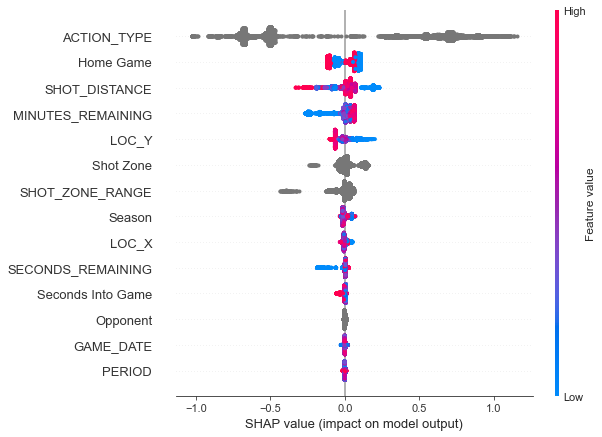

In [131]:
shap.summary_plot(shap_values, x_columns_Curry)

#### Can add more SHAP plots here